# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [1]:
# Import essential libraries for data manipulation and analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import datetime


## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [2]:
# Importing the file porter_data_1.csv
df = pd.read_csv('porter_data_1.csv')

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head(20))
print("\nDataset info:")
print(df.info())


Dataset shape: (175777, 14)

First few rows:
    market_id           created_at actual_delivery_time  \
0         1.0  2015-02-06 22:24:17  2015-02-06 23:11:17   
1         2.0  2015-02-10 21:49:25  2015-02-10 22:33:25   
2         2.0  2015-02-16 00:11:35  2015-02-16 01:06:35   
3         1.0  2015-02-12 03:36:46  2015-02-12 04:35:46   
4         1.0  2015-01-27 02:12:36  2015-01-27 02:58:36   
5         1.0  2015-02-06 00:42:42  2015-02-06 01:38:42   
6         1.0  2015-02-08 02:04:17  2015-02-08 03:07:17   
7         1.0  2015-01-31 04:35:54  2015-01-31 05:33:54   
8         1.0  2015-01-31 02:21:23  2015-01-31 02:58:23   
9         1.0  2015-01-31 23:45:12  2015-02-01 00:26:12   
10        1.0  2015-02-17 03:13:20  2015-02-17 04:08:20   
11        1.0  2015-02-15 01:26:20  2015-02-15 02:11:20   
12        1.0  2015-02-02 05:27:49  2015-02-02 06:54:49   
13        1.0  2015-02-16 02:21:20  2015-02-16 03:28:20   
14        1.0  2015-02-13 01:01:58  2015-02-13 01:44:58   
15        1

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [3]:
# 2.1.1 Converting timestamps to datetime
# Convert 'created_at' and 'actual_delivery_time' to datetime
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

# Create delivery duration in minutes (this will be our target variable)
df['delivery_duration'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

# Extract additional time-based features
df['hour_of_day'] = df['created_at'].dt.hour
df['day_of_week'] = df['created_at'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Verify the conversions
print("\nUpdated data types:")
print(df.dtypes)

# Display basic statistics of the delivery duration
print("\nDelivery Duration Statistics (in minutes):")
print(df['delivery_duration'].describe())

# Check for any potential outliers or invalid durations
print("\nNumber of orders with negative duration:", 
      len(df[df['delivery_duration'] < 0]))
print("Number of orders with duration > 180 minutes:", 
      len(df[df['delivery_duration'] > 180]))


Updated data types:
market_id                          float64
created_at                  datetime64[ns]
actual_delivery_time        datetime64[ns]
store_primary_category               int64
order_protocol                     float64
total_items                          int64
subtotal                             int64
num_distinct_items                   int64
min_item_price                       int64
max_item_price                       int64
total_onshift_dashers              float64
total_busy_dashers                 float64
total_outstanding_orders           float64
distance                           float64
delivery_duration                  float64
hour_of_day                          int32
day_of_week                          int32
is_weekend                           int32
dtype: object

Delivery Duration Statistics (in minutes):
count    175777.000000
mean         46.203013
std           9.327424
min          32.000000
25%          39.000000
50%          45.000000
75%      

##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [4]:
df['market_id'] = df['market_id'].astype('category')

#Convert store_primary_category to categorical
df['store_primary_category'] = df['store_primary_category'].astype('category')

# Convert order_protocol to categorical if not already encoded
if 'order_protocol' in df.columns:  # Check if the column exists
    df['order_protocol'] = df['order_protocol'].astype('category')

# Create a list of numeric features (for later use in modeling)
numeric_features = ['total_items', 'subtotal', 'num_distinct_items', 
                   'min_item_price', 'max_item_price', 'total_onshift_dashers',
                   'total_busy_dashers', 'total_outstanding_orders', 'distance']

# Verify the data types after conversion
print("Updated data types after conversion:")
print(df.dtypes)

# Display summary of categorical variables
print("\nUnique values in categorical variables:")
for col in df.select_dtypes(include=['category']).columns:
    print(f"\n{col}:")
    print(df[col].value_counts().head())

# Basic statistics of numeric features
print("\nSummary statistics of numeric features:")
print(df[numeric_features].describe())

Updated data types after conversion:
market_id                         category
created_at                  datetime64[ns]
actual_delivery_time        datetime64[ns]
store_primary_category            category
order_protocol                    category
total_items                          int64
subtotal                             int64
num_distinct_items                   int64
min_item_price                       int64
max_item_price                       int64
total_onshift_dashers              float64
total_busy_dashers                 float64
total_outstanding_orders           float64
distance                           float64
delivery_duration                  float64
hour_of_day                          int32
day_of_week                          int32
is_weekend                           int32
dtype: object

Unique values in categorical variables:

market_id:
market_id
2.0    53469
4.0    46222
1.0    37115
3.0    21075
5.0    17258
Name: count, dtype: int64

store_primary_catego

#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

Delivery Duration Statistics (in minutes):
count    175777.000000
mean         46.203013
std           9.327424
min          32.000000
25%          39.000000
50%          45.000000
75%          52.000000
max         110.000000
Name: delivery_duration, dtype: float64

Delivery Duration by Hour:
       mean  count
hour              
0     46.36  11464
1     47.69  25722
2     50.69  32896
3     50.18  23693
4     45.96  13248
5     44.35   6078
6     45.05   1223
7     44.67      9
8     46.50      2
14    46.29     38
15    45.33    502
16    44.15   1936
17    43.61   3058
18    42.40   4514
19    43.53  12083
20    41.65  13883
21    40.15  10219
22    40.70   7875
23    41.33   7334

Delivery Duration by Day of Week (0=Monday, 6=Sunday):
              mean  count
day_of_week              
0            48.65  24202
1            44.54  21483
2            43.64  21753
3            44.91  22584
4            44.41  25004
5            48.48  30858
6            47.41  29893


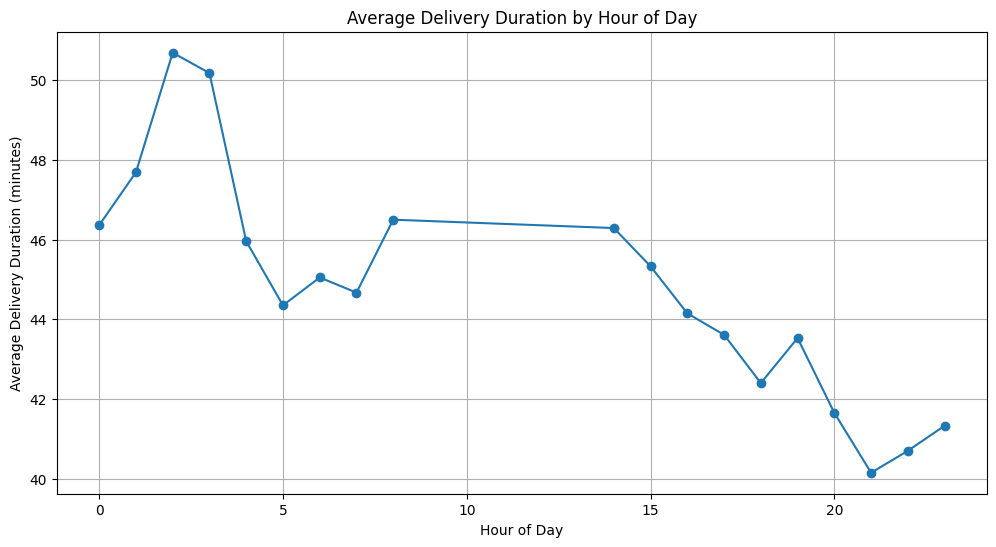


Checking for potential anomalies:
Minimum duration: 32.00 minutes
Maximum duration: 110.00 minutes
Number of orders with duration < 10 minutes: 0
Number of orders with duration > 120 minutes: 0


In [5]:
# Calculate time taken in minutes

# Calculate delivery duration
df['delivery_duration'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

# Extract time-based features
df['hour'] = df['created_at'].dt.hour
df['day'] = df['created_at'].dt.day
df['month'] = df['created_at'].dt.month
df['day_of_week'] = df['created_at'].dt.dayofweek

# Calculate some basic statistics for delivery duration
print("Delivery Duration Statistics (in minutes):")
print(df['delivery_duration'].describe())

# Analyze delivery duration by hour
hourly_stats = df.groupby('hour')['delivery_duration'].agg(['mean', 'count']).round(2)
print("\nDelivery Duration by Hour:")
print(hourly_stats)

# Analyze delivery duration by day of week
day_stats = df.groupby('day_of_week')['delivery_duration'].agg(['mean', 'count']).round(2)
print("\nDelivery Duration by Day of Week (0=Monday, 6=Sunday):")
print(day_stats)

# Create a visualization of average delivery duration by hour
plt.figure(figsize=(12, 6))
plt.plot(hourly_stats.index, hourly_stats['mean'], marker='o')
plt.title('Average Delivery Duration by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Delivery Duration (minutes)')
plt.grid(True)
plt.show()

# Check for any anomalies in the calculated duration
print("\nChecking for potential anomalies:")
print(f"Minimum duration: {df['delivery_duration'].min():.2f} minutes")
print(f"Maximum duration: {df['delivery_duration'].max():.2f} minutes")
print(f"Number of orders with duration < 10 minutes: {len(df[df['delivery_duration'] < 10])}")
print(f"Number of orders with duration > 120 minutes: {len(df[df['delivery_duration'] > 120])}")

##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [6]:
# 2.2.2 Extract hour, day of week and drop unnecessary columns

# First, let's create a copy of our dataframe to work with
df_cleaned = df.copy()

# Keep only the necessary columns
columns_to_keep = [
    'market_id',
    'store_primary_category',
    'order_protocol',
    'total_items',
    'subtotal',
    'num_distinct_items',
    'min_item_price',
    'max_item_price',
    'total_onshift_dashers',
    'total_busy_dashers',
    'total_outstanding_orders',
    'distance',
    'delivery_duration',  # target variable
    'hour',              # extracted time feature
    'day_of_week'        # extracted day feature
]


In [7]:
# Drop unnecessary columns

# Drop unnecessary columns and keep only the ones we need
df_cleaned = df_cleaned[columns_to_keep]

# Create time-based categorical features
df_cleaned['is_night'] = (df_cleaned['hour'] >= 22) | (df_cleaned['hour'] <= 4)
df_cleaned['is_weekend'] = df_cleaned['day_of_week'].isin([5, 6])

# Convert boolean columns to int
df_cleaned['is_night'] = df_cleaned['is_night'].astype(int)
df_cleaned['is_weekend'] = df_cleaned['is_weekend'].astype(int)

# Display the structure of our cleaned dataset
print("Cleaned dataset structure:")
print(df_cleaned.info())

# Display first few rows of the cleaned dataset
print("\nFirst few rows of cleaned dataset:")
print(df_cleaned.head())

# Basic statistics of the cleaned dataset
print("\nBasic statistics of numeric features:")
print(df_cleaned.describe())

# Verify no missing values
print("\nMissing values check:")
print(df_cleaned.isnull().sum())

Cleaned dataset structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   market_id                 175777 non-null  category
 1   store_primary_category    175777 non-null  category
 2   order_protocol            175777 non-null  category
 3   total_items               175777 non-null  int64   
 4   subtotal                  175777 non-null  int64   
 5   num_distinct_items        175777 non-null  int64   
 6   min_item_price            175777 non-null  int64   
 7   max_item_price            175777 non-null  int64   
 8   total_onshift_dashers     175777 non-null  float64 
 9   total_busy_dashers        175777 non-null  float64 
 10  total_outstanding_orders  175777 non-null  float64 
 11  distance                  175777 non-null  float64 
 12  delivery_duration         175777 non-null  float64 
 13  ho

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [8]:
# Define target variable (y) and features (X)
# Target variable
y = df_cleaned['delivery_duration']

# Features to exclude from X
exclude_columns = ['delivery_duration']

# Input features (X) - all columns except the target
X = df_cleaned.drop(exclude_columns, axis=1)

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, columns=['market_id', 'store_primary_category', 'order_protocol'])



##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [9]:
split_point = int(len(X) * 0.8)

# Create train-test split
X_train = X[:split_point]
X_test = X[split_point:]
y_train = y[:split_point]
y_test = y[split_point:]

# Scale numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Identify numerical columns (excluding dummy variables)
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns
print("\nNumerical columns to be scaled:")
print(numerical_columns.tolist())

# Scale numerical features for training data
X_train_scaled = X_train.copy()
X_train_scaled[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])

# Scale numerical features for test data
X_test_scaled = X_test.copy()
X_test_scaled[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Print information about the split
print("\nDataset shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

# Basic statistics of the split
print("\nTraining set delivery duration statistics:")
print(y_train.describe())
print("\nTest set delivery duration statistics:")
print(y_test.describe())

# Verify scaling worked correctly
print("\nScaled features statistics (training set sample):")
print(X_train_scaled[numerical_columns].describe().round(2))

print("\nScaled features statistics (test set sample):")
print(X_test_scaled[numerical_columns].describe().round(2))




Numerical columns to be scaled:
['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance']

Dataset shapes:
X_train: (140621, 99)
X_test: (35156, 99)
y_train: (140621,)
y_test: (35156,)

Training set delivery duration statistics:
count    140621.000000
mean         46.248967
std           9.338830
min          32.000000
25%          39.000000
50%          45.000000
75%          52.000000
max         110.000000
Name: delivery_duration, dtype: float64

Test set delivery duration statistics:
count    35156.000000
mean        46.019200
std          9.279521
min         32.000000
25%         39.000000
50%         45.000000
75%         52.000000
max         99.000000
Name: delivery_duration, dtype: float64

Scaled features statistics (training set sample):
       total_items   subtotal  num_distinct_items  min_item_price  \
count    140621.00  140621.00           140621.00      

<h5>Plotting to check if test and train data are similar

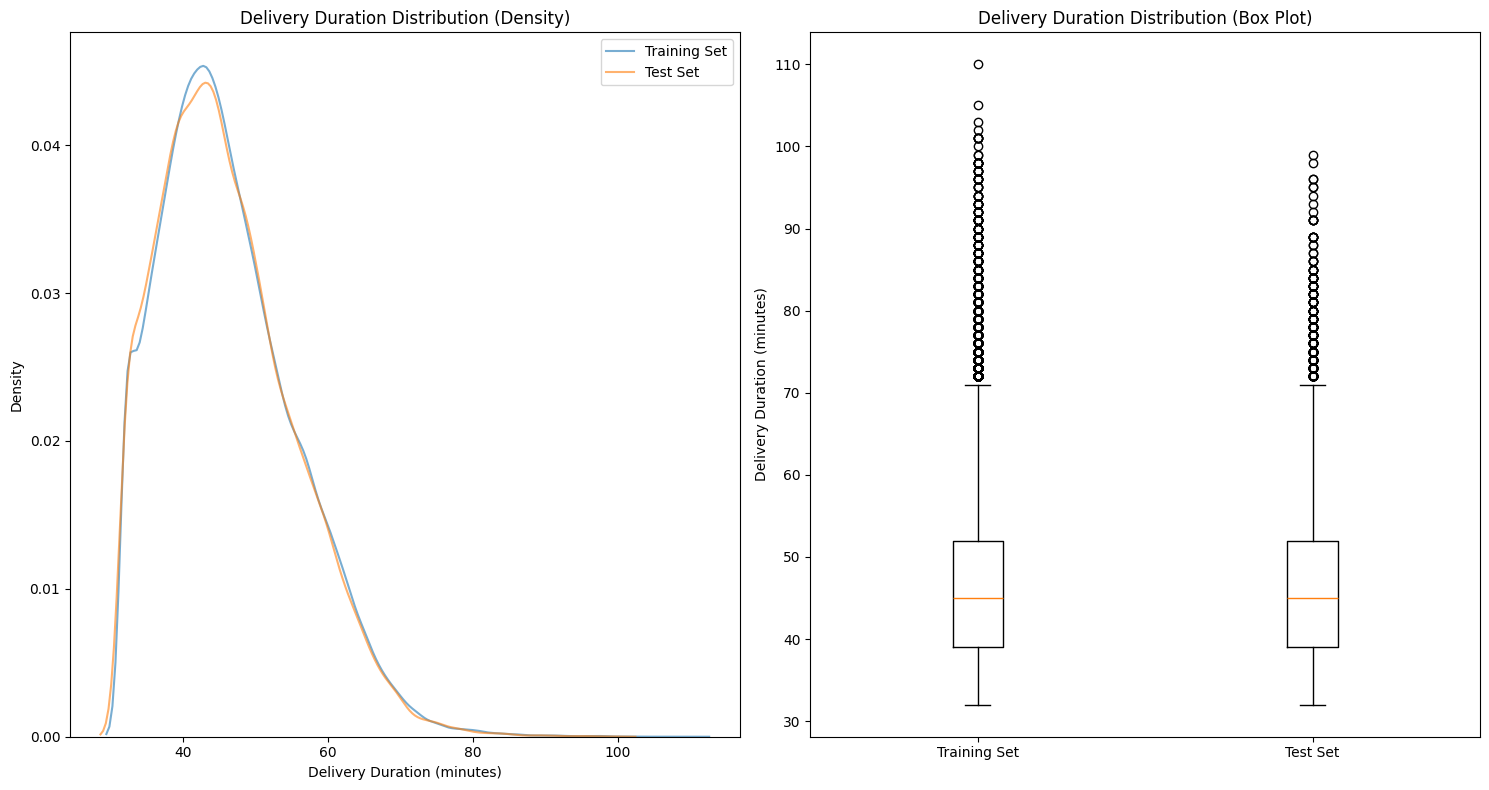

Detailed Statistics Comparison:
        Training Set      Test Set
count  140621.000000  35156.000000
mean       46.248967     46.019200
std         9.338830      9.279521
min        32.000000     32.000000
25%        39.000000     39.000000
50%        45.000000     45.000000
75%        52.000000     52.000000
max       110.000000     99.000000

Kolmogorov-Smirnov test:
KS statistic: 0.0124
p-value: 0.0003

Percentage of samples in different ranges:
            Training Set (%)  Test Set (%)
< 40 mins              26.05         27.29
40-50 mins             41.60         40.95
50-60 mins             22.64         22.55
≥ 60 mins               9.70          9.21


In [10]:
plt.figure(figsize=(15, 8))

# Plot 1: Normalized histogram (density) for both train and test
plt.subplot(1, 2, 1)
sns.kdeplot(data=y_train, label='Training Set', alpha=0.6)
sns.kdeplot(data=y_test, label='Test Set', alpha=0.6)
plt.title('Delivery Duration Distribution (Density)')
plt.xlabel('Delivery Duration (minutes)')
plt.ylabel('Density')
plt.legend()

# Plot 2: Box plot comparison
plt.subplot(1, 2, 2)
plt.boxplot([y_train, y_test], tick_labels=['Training Set', 'Test Set'])
plt.title('Delivery Duration Distribution (Box Plot)')
plt.ylabel('Delivery Duration (minutes)')

plt.tight_layout()
plt.show()

# Print detailed statistics comparison
print("Detailed Statistics Comparison:")
stats_comparison = pd.DataFrame({
    'Training Set': y_train.describe(),
    'Test Set': y_test.describe()
})
print(stats_comparison)

# Calculate and print distribution similarity metrics
from scipy import stats

# Perform Kolmogorov-Smirnov test
ks_statistic, p_value = stats.ks_2samp(y_train, y_test)
print("\nKolmogorov-Smirnov test:")
print(f"KS statistic: {ks_statistic:.4f}")
print(f"p-value: {p_value:.4f}")

# Calculate percentage of samples in different ranges
def distribution_ranges(data):
    return {
        '< 40 mins': (data < 40).mean() * 100,
        '40-50 mins': ((data >= 40) & (data < 50)).mean() * 100,
        '50-60 mins': ((data >= 50) & (data < 60)).mean() * 100,
        '≥ 60 mins': (data >= 60).mean() * 100
    }

train_ranges = distribution_ranges(y_train)
test_ranges = distribution_ranges(y_test)

print("\nPercentage of samples in different ranges:")
ranges_comparison = pd.DataFrame({
    'Training Set (%)': train_ranges,
    'Test Set (%)': test_ranges
})
print(ranges_comparison.round(2))

## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [11]:
# Define numerical and categorical columns for easy EDA and data manipulation
numerical_columns = ['total_items', 'subtotal', 'num_distinct_items', 
                    'min_item_price', 'max_item_price', 'total_onshift_dashers',
                    'total_busy_dashers', 'total_outstanding_orders', 'distance']


##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

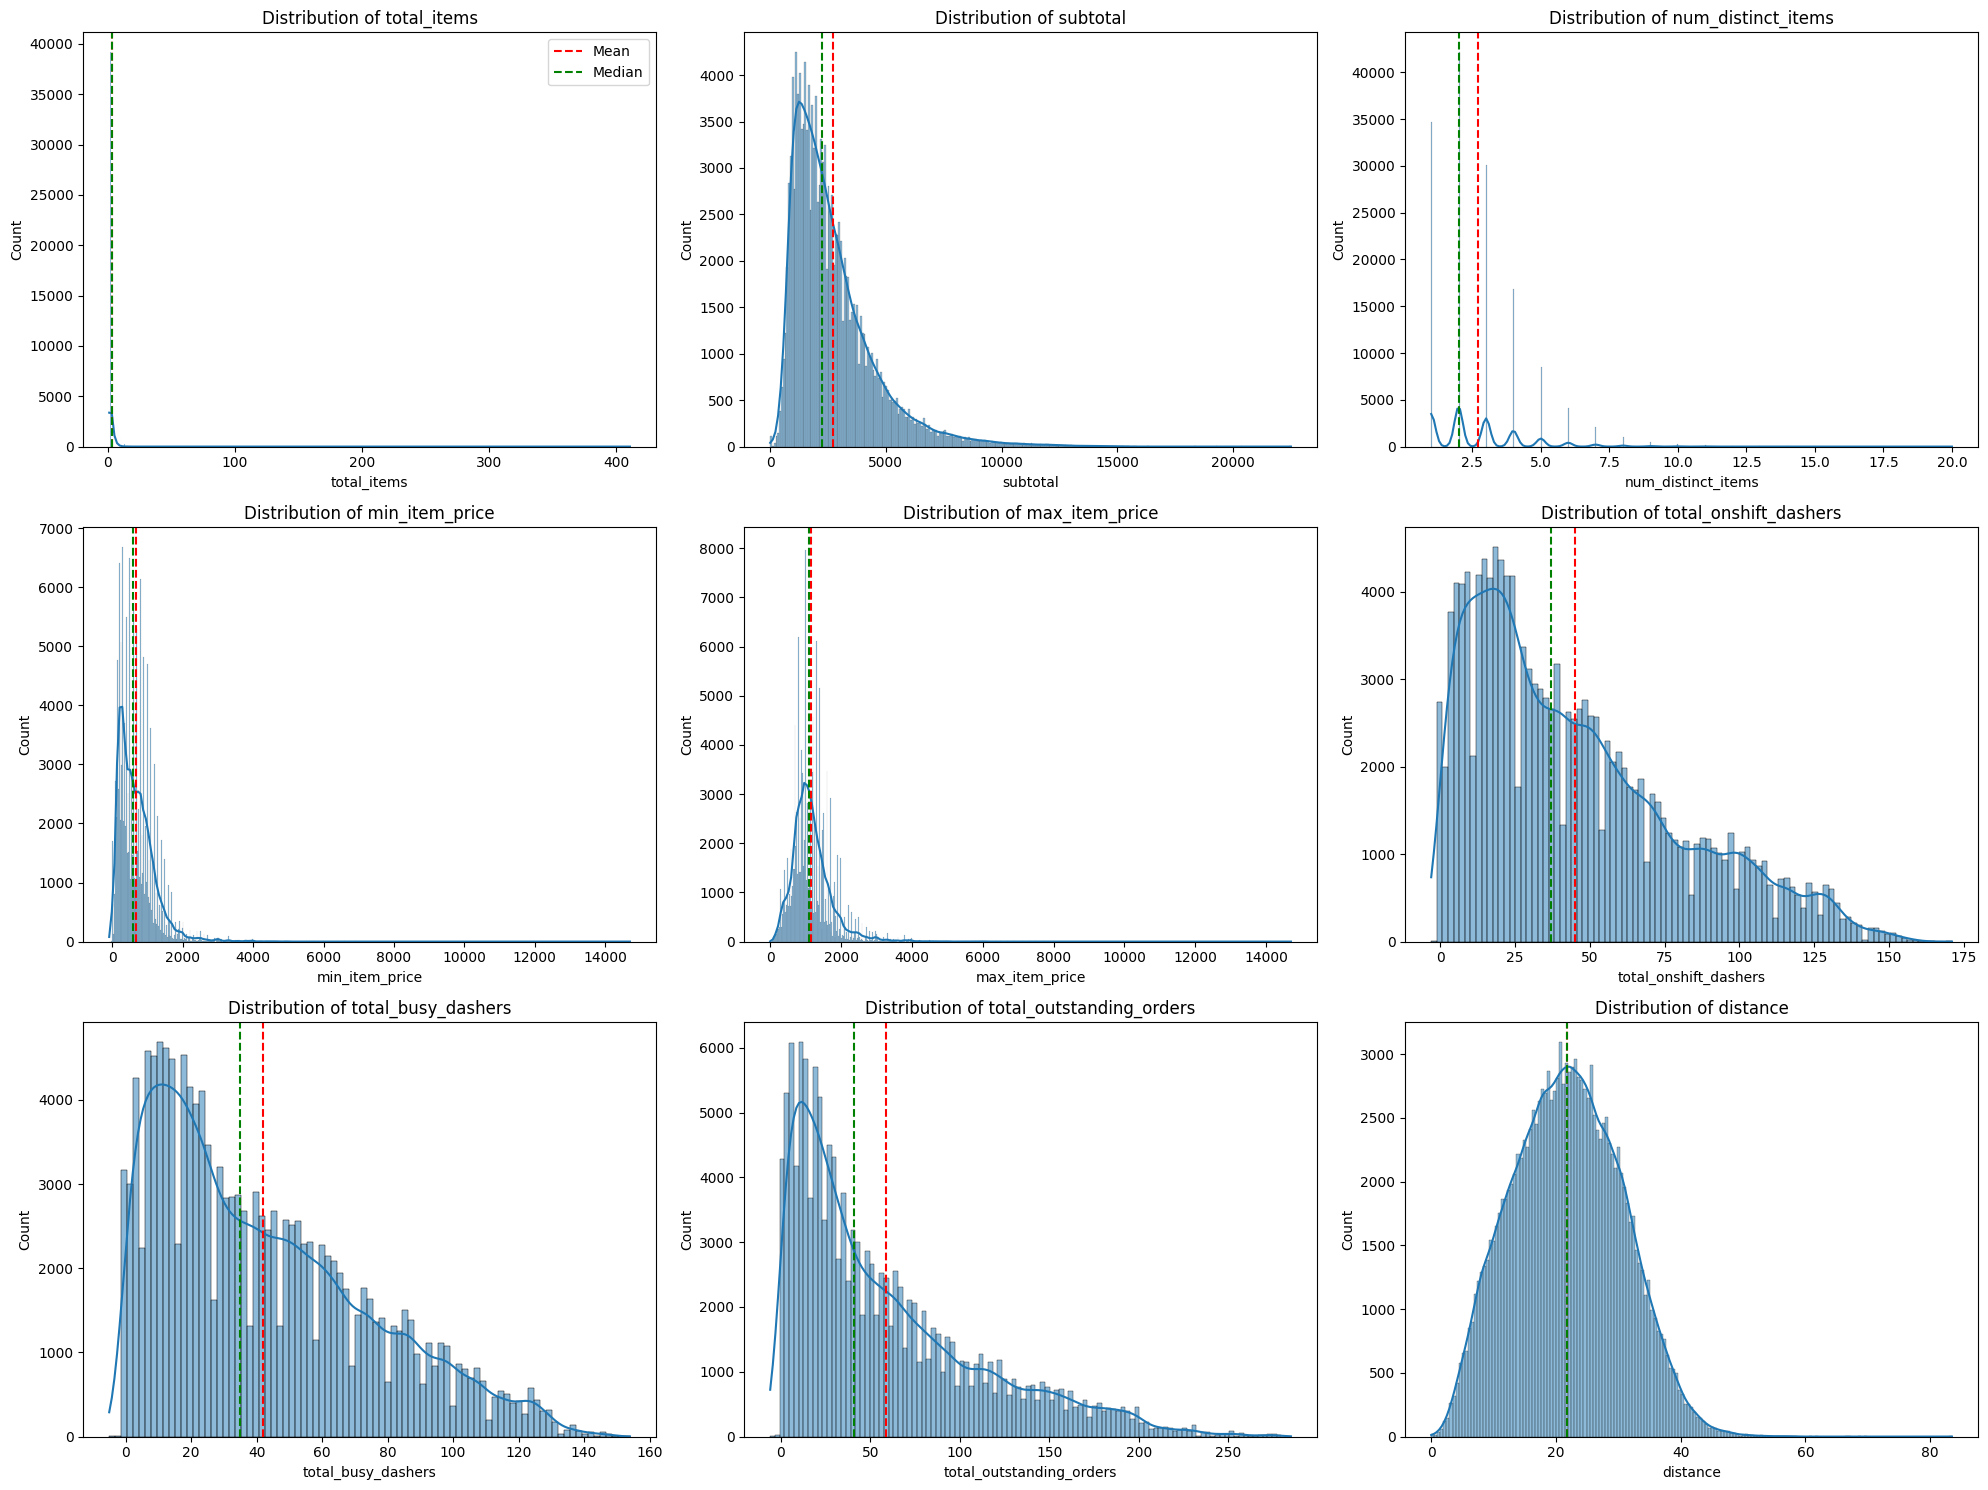

Summary Statistics for Numerical Features:
                             Mean   Median      Std  Skewness  Kurtosis
total_items                  3.22     3.00     2.73     26.75   3588.30
subtotal                  2710.80  2242.00  1836.20      1.90      5.40
num_distinct_items           2.69     2.00     1.63      1.58      4.30
min_item_price             684.06   595.00   518.68      2.28     14.52
max_item_price            1163.31  1095.00   563.33      2.15     12.83
total_onshift_dashers       45.08    37.00    34.68      0.85     -0.06
total_busy_dashers          42.00    35.00    32.26      0.78     -0.21
total_outstanding_orders    58.45    41.00    52.95      1.19      0.83
distance                    21.81    21.72     8.75      0.14     -0.40

Percentage of Outliers in Each Feature:
                          Outliers %
total_items                     4.87
subtotal                        4.55
num_distinct_items             12.01
min_item_price                  2.35
max_item_pr

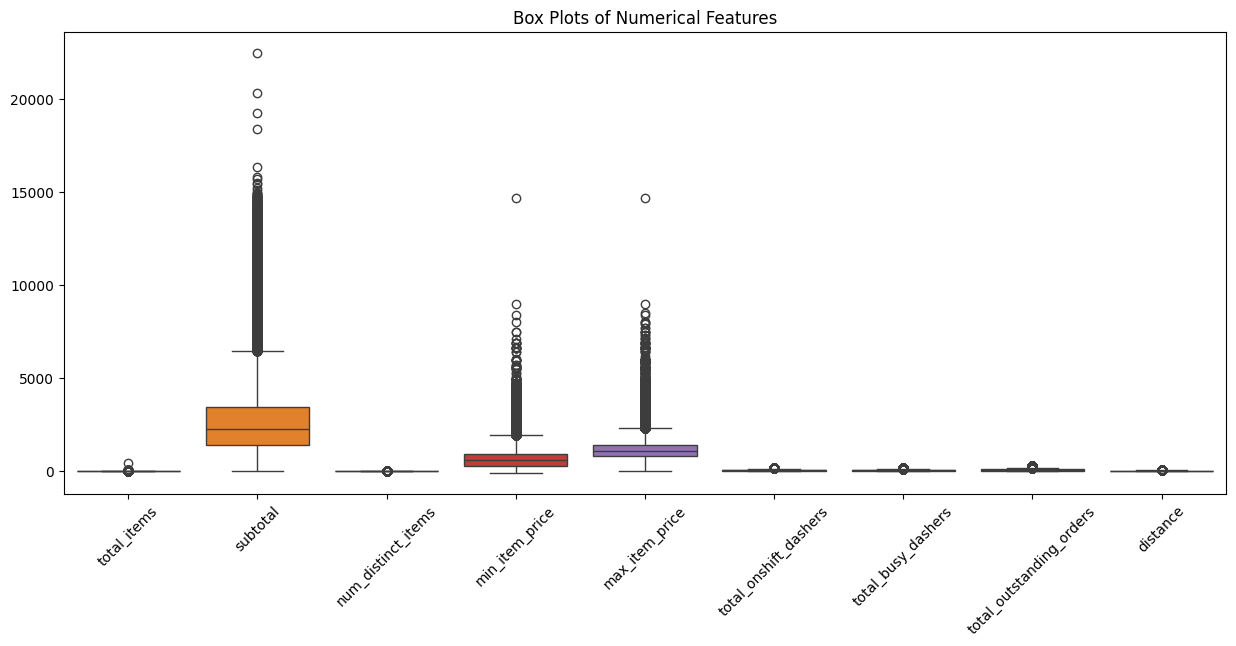


Correlations with Delivery Duration:
                          Correlation with Delivery Duration
distance                                            0.456982
subtotal                                            0.417949
total_outstanding_orders                            0.394619
num_distinct_items                                  0.313696
max_item_price                                      0.261772
total_items                                         0.221221
total_busy_dashers                                  0.217557
total_onshift_dashers                               0.180989
min_item_price                                      0.024801


In [12]:
# Plot distributions for all numerical columns

# Create a figure for distribution plots
plt.figure(figsize=(20, 15))

# Plot distributions for each numerical column
for idx, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, idx)
    
    # Plot histogram and KDE
    sns.histplot(data=X_train[col], kde=True)
    
    # Add mean and median lines
    plt.axvline(X_train[col].mean(), color='red', linestyle='--', label='Mean')
    plt.axvline(X_train[col].median(), color='green', linestyle='--', label='Median')
    
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    if idx == 1:  # Only add legend for the first plot
        plt.legend()

plt.tight_layout()
plt.show()

# Calculate and display summary statistics
print("Summary Statistics for Numerical Features:")
stats_df = pd.DataFrame({
    'Mean': X_train[numerical_columns].mean(),
    'Median': X_train[numerical_columns].median(),
    'Std': X_train[numerical_columns].std(),
    'Skewness': X_train[numerical_columns].skew(),
    'Kurtosis': X_train[numerical_columns].kurtosis()
}).round(2)
print(stats_df)

# Calculate and display the percentage of outliers for each feature
def calculate_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((data < lower_bound) | (data > upper_bound)).sum() / len(data) * 100
    return outliers

print("\nPercentage of Outliers in Each Feature:")
outliers_df = pd.DataFrame({
    'Outliers %': X_train[numerical_columns].apply(calculate_outliers)
}).round(2)
print(outliers_df)

# Additional visualization: Box plots for all numerical features
plt.figure(figsize=(15, 6))
sns.boxplot(data=X_train[numerical_columns])
plt.xticks(rotation=45)
plt.title('Box Plots of Numerical Features')
plt.show()

# Correlation with target variable
correlations = pd.DataFrame({
    'Correlation with Delivery Duration': X_train[numerical_columns].corrwith(y_train)
}).sort_values('Correlation with Delivery Duration', ascending=False)
print("\nCorrelations with Delivery Duration:")
print(correlations)



##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140621 entries, 0 to 140620
Data columns (total 99 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   total_items                140621 non-null  int64  
 1   subtotal                   140621 non-null  int64  
 2   num_distinct_items         140621 non-null  int64  
 3   min_item_price             140621 non-null  int64  
 4   max_item_price             140621 non-null  int64  
 5   total_onshift_dashers      140621 non-null  float64
 6   total_busy_dashers         140621 non-null  float64
 7   total_outstanding_orders   140621 non-null  float64
 8   distance                   140621 non-null  float64
 9   hour                       140621 non-null  int32  
 10  day_of_week                140621 non-null  int32  
 11  is_night                   140621 non-null  int32  
 12  is_weekend                 140621 non-null  int32  
 13  market_id_1.0              14

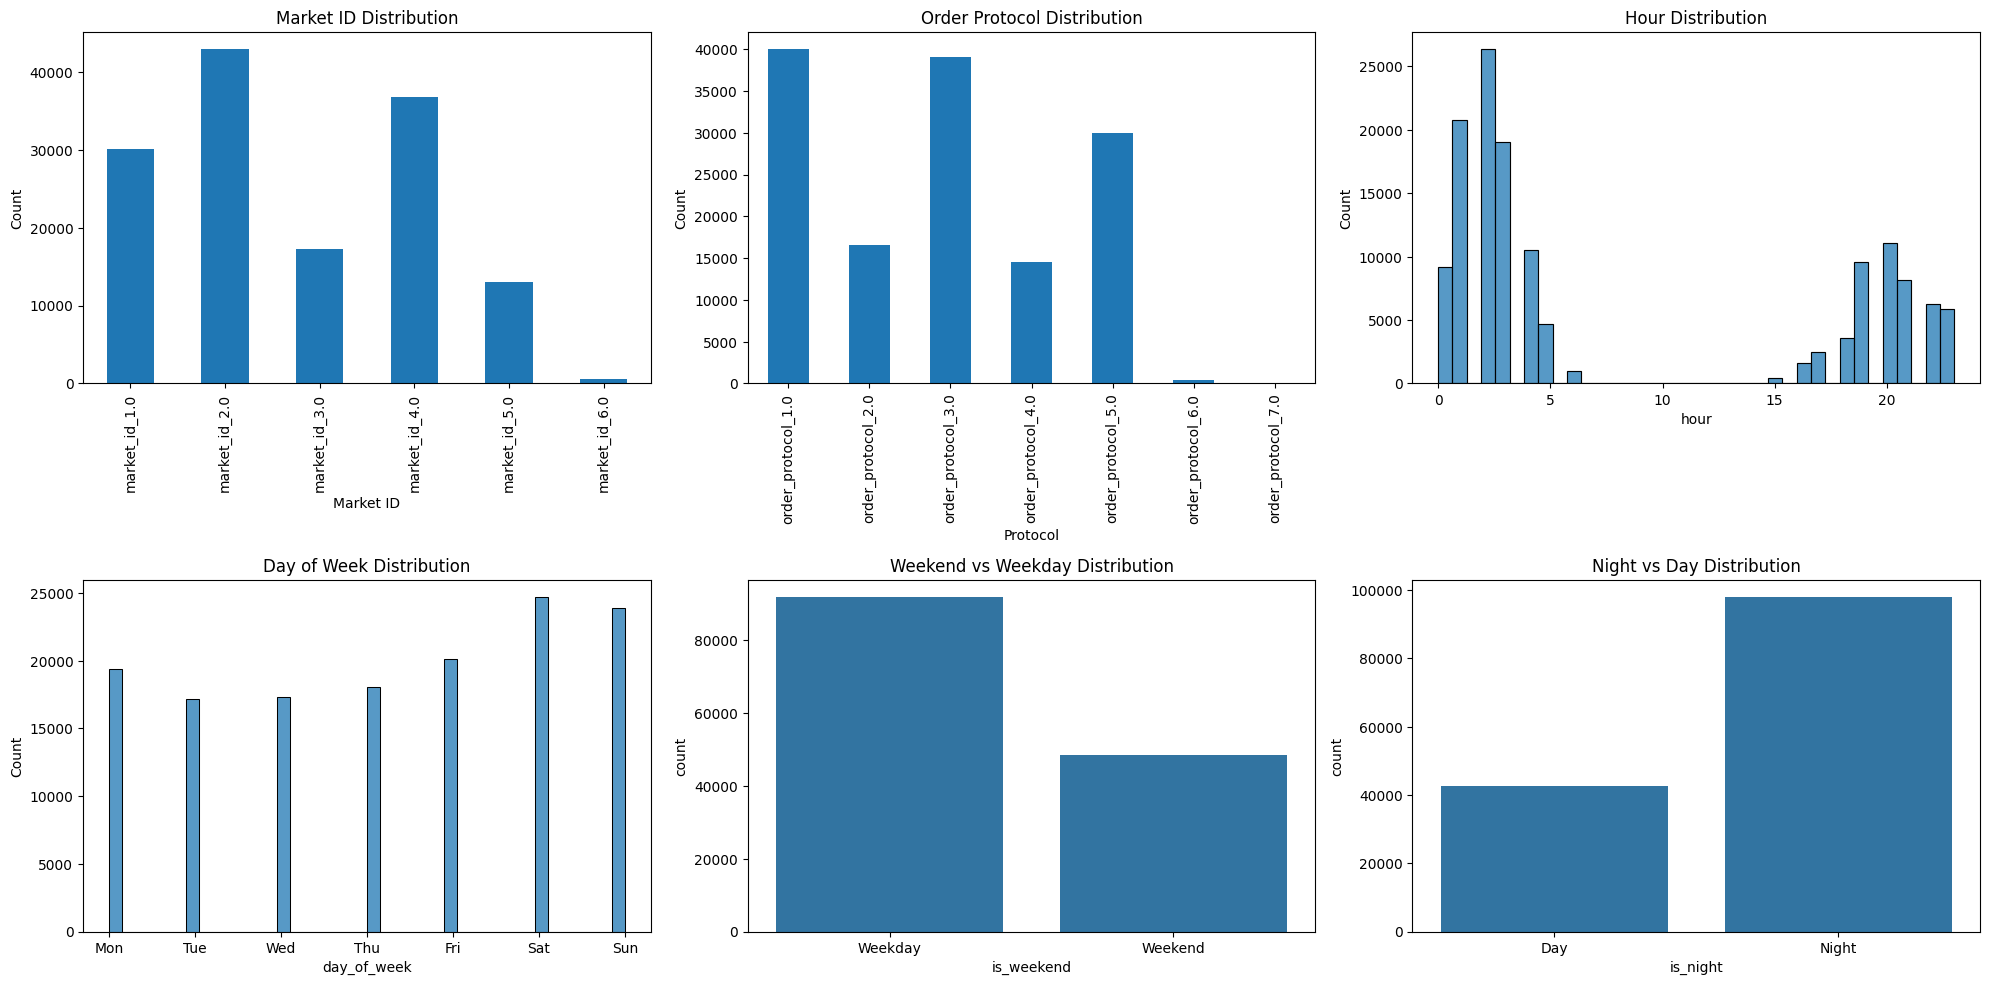


Categorical Features Distribution:

1. Market ID Distribution:
market_id_1.0    21.38
market_id_2.0    30.57
market_id_3.0    12.26
market_id_4.0    26.16
market_id_5.0     9.25
market_id_6.0     0.37
dtype: float64

2. Order Protocol Distribution:
order_protocol_1.0    28.48
order_protocol_2.0    11.76
order_protocol_3.0    27.77
order_protocol_4.0    10.36
order_protocol_5.0    21.35
order_protocol_6.0     0.27
order_protocol_7.0     0.01
dtype: float64

3. Hour Distribution:
hour
0      9210
1     20752
2     26399
3     19045
4     10488
5      4713
6       952
7         6
8         1
14       29
15      405
16     1612
17     2461
18     3613
19     9552
20    11087
21     8147
22     6288
23     5861

4. Day of Week Distribution:
day_of_week
Friday       20108
Monday       19362
Saturday     24722
Sunday       23914
Thursday     18043
Tuesday      17170
Wednesday    17302

5. Weekend/Weekday Distribution:
Weekday: 65.41%
Weekend: 34.59%

6. Night/Day Distribution:
Day: 30.28%
Ni

In [14]:

def plot_categorical_distributions():
    # Original categorical features
    categorical_features = ['market_id', 'store_primary_category', 'order_protocol', 
                          'is_weekend', 'is_night', 'hour', 'day_of_week']
    
    # Create subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Market ID distribution
    plt.subplot(3, 3, 1)
    market_dist = X_train[['market_id_1.0', 'market_id_2.0', 'market_id_3.0', 
                          'market_id_4.0', 'market_id_5.0', 'market_id_6.0']].sum()
    market_dist.plot(kind='bar')
    plt.title('Market ID Distribution')
    plt.xlabel('Market ID')
    plt.ylabel('Count')
    
    # 2. Order Protocol distribution
    plt.subplot(3, 3, 2)
    protocol_dist = X_train[['order_protocol_1.0', 'order_protocol_2.0', 'order_protocol_3.0',
                            'order_protocol_4.0', 'order_protocol_5.0', 'order_protocol_6.0',
                            'order_protocol_7.0']].sum()
    protocol_dist.plot(kind='bar')
    plt.title('Order Protocol Distribution')
    plt.xlabel('Protocol')
    plt.ylabel('Count')
    
    # 3. Hour distribution
    plt.subplot(3, 3, 3)
    sns.histplot(data=X_train, x='hour')
    plt.title('Hour Distribution')
    
    # 4. Day of Week distribution
    plt.subplot(3, 3, 4)
    sns.histplot(data=X_train, x='day_of_week')
    plt.title('Day of Week Distribution')
    plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    
    # 5. Weekend/Weekday distribution
    plt.subplot(3, 3, 5)
    sns.countplot(data=X_train, x='is_weekend')
    plt.title('Weekend vs Weekday Distribution')
    plt.xticks([0, 1], ['Weekday', 'Weekend'])
    
    # 6. Night/Day distribution
    plt.subplot(3, 3, 6)
    sns.countplot(data=X_train, x='is_night')
    plt.title('Night vs Day Distribution')
    plt.xticks([0, 1], ['Day', 'Night'])
    
    plt.tight_layout()
    plt.show()

    # Print detailed statistics
    print("\nCategorical Features Distribution:")
    
    print("\n1. Market ID Distribution:")
    market_dist_pct = (X_train[['market_id_1.0', 'market_id_2.0', 'market_id_3.0',
                               'market_id_4.0', 'market_id_5.0', 'market_id_6.0']].sum() / len(X_train) * 100).round(2)
    print(market_dist_pct)
    
    print("\n2. Order Protocol Distribution:")
    protocol_dist_pct = (X_train[['order_protocol_1.0', 'order_protocol_2.0', 'order_protocol_3.0',
                                 'order_protocol_4.0', 'order_protocol_5.0', 'order_protocol_6.0',
                                 'order_protocol_7.0']].sum() / len(X_train) * 100).round(2)
    print(protocol_dist_pct)
    
    print("\n3. Hour Distribution:")
    print(X_train['hour'].value_counts().sort_index().to_string())
    
    print("\n4. Day of Week Distribution:")
    day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 
                  3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
    print(X_train['day_of_week'].map(day_mapping).value_counts().sort_index().to_string())
    
    print("\n5. Weekend/Weekday Distribution:")
    weekend_pct = (X_train['is_weekend'].value_counts() / len(X_train) * 100).round(2)
    print("Weekday: {}%".format(weekend_pct[0]))
    print("Weekend: {}%".format(weekend_pct[1]))
    
    print("\n6. Night/Day Distribution:")
    night_pct = (X_train['is_night'].value_counts() / len(X_train) * 100).round(2)
    print("Day: {}%".format(night_pct[0]))
    print("Night: {}%".format(night_pct[1]))

# Run the analysis
plot_categorical_distributions()

# Additional analysis: Average delivery duration by categorical features
print("\nAverage Delivery Duration by Categories:")

print("\nBy Market ID:")
market_cols = [col for col in X_train.columns if col.startswith('market_id')]
for col in market_cols:
    avg_duration = y_train[X_train[col] == 1].mean()
    print(f"{col}: {avg_duration:.2f} minutes")

print("\nBy Order Protocol:")
protocol_cols = [col for col in X_train.columns if col.startswith('order_protocol')]
for col in protocol_cols:
    avg_duration = y_train[X_train[col] == 1].mean()
    print(f"{col}: {avg_duration:.2f} minutes")

##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

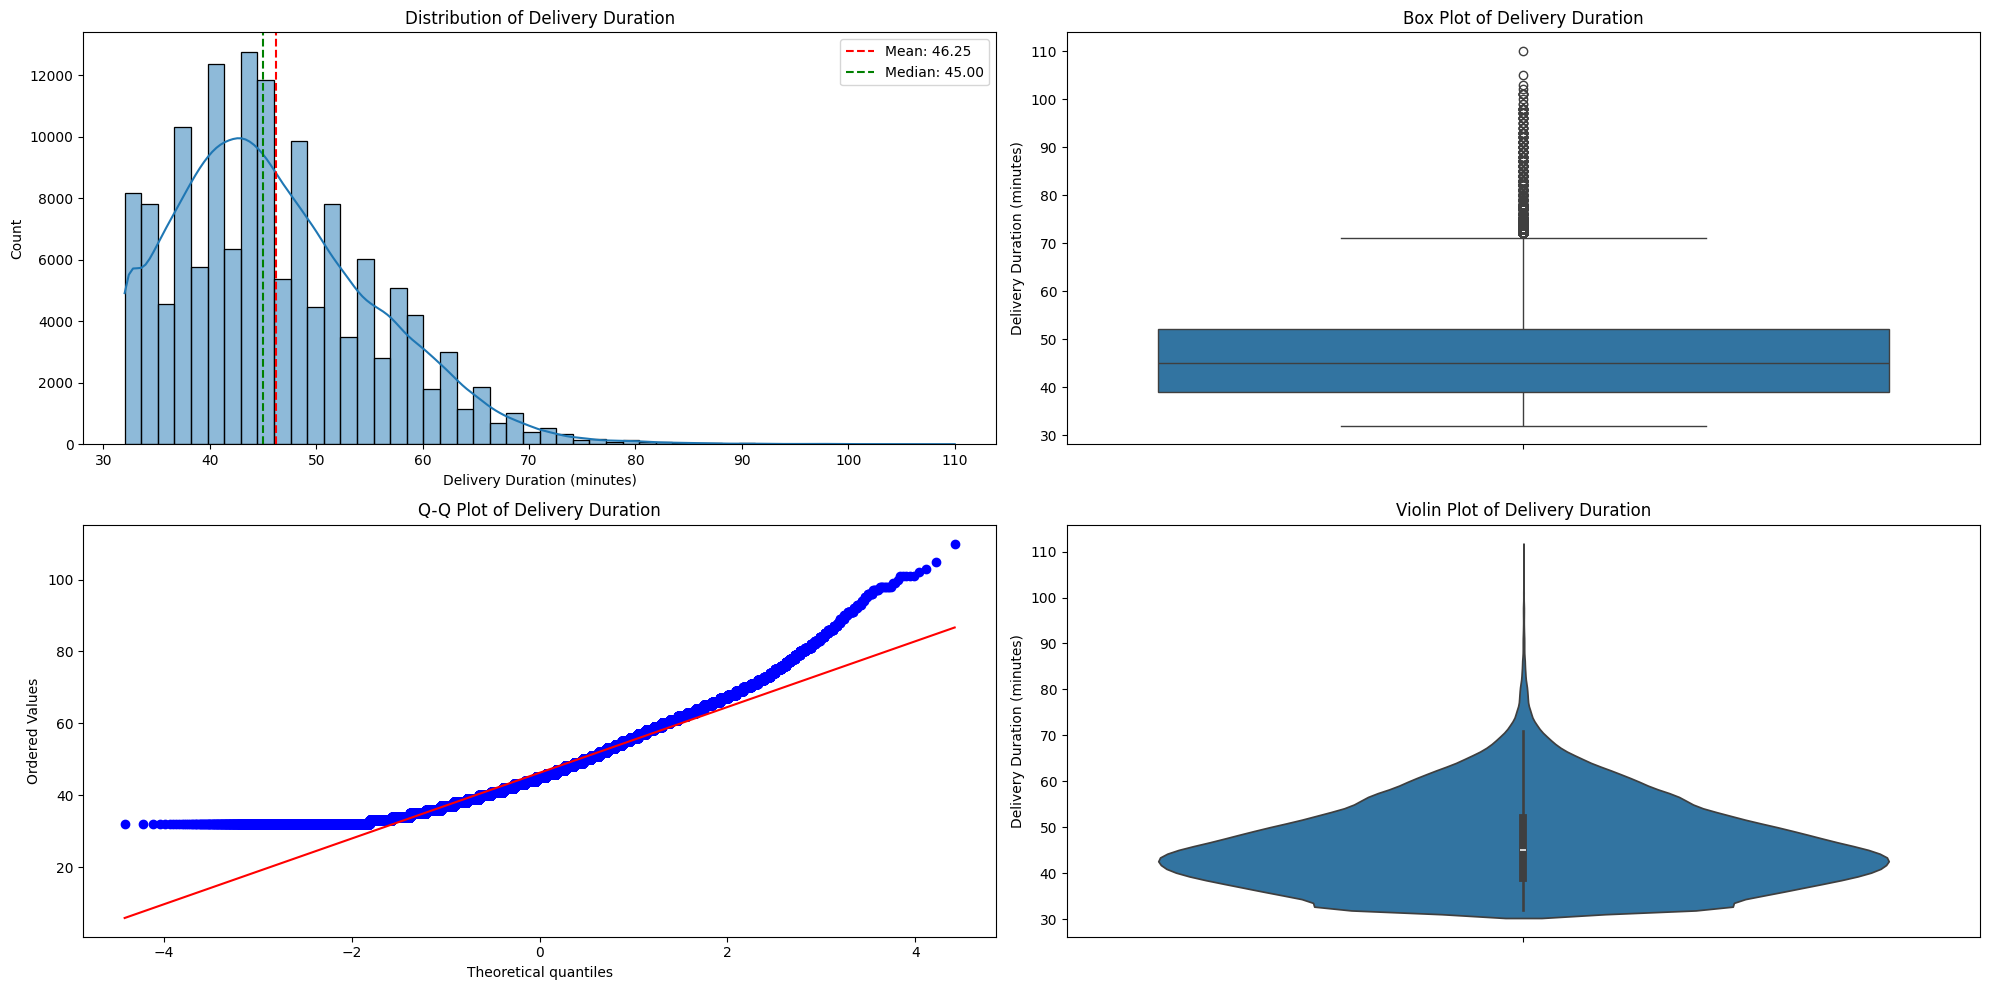


Detailed Statistics of Delivery Duration:
Mean: 46.25
Median: 45.00
Standard Deviation: 9.34
Skewness: 0.77
Kurtosis: 0.64
Min: 32.00
Max: 110.00
25th Percentile: 39.00
75th Percentile: 52.00
IQR: 13.00

Delivery Duration Ranges:
0-35 mins: 8.43%
35-40 mins: 17.62%
40-45 mins: 22.38%
45-50 mins: 19.23%
50-55 mins: 13.42%
55-60 mins: 9.23%
60+ mins: 9.70%

Normality Test:
Statistic: 12401.10
P-value: 0.0000000000
Distribution is {'normal' if p_value > 0.05 else 'not normal'}


In [15]:
# Distribution of time_taken
# Create a figure with multiple plots
fig = plt.figure(figsize=(20, 10))

# 1. Histogram with KDE
plt.subplot(2, 2, 1)
sns.histplot(data=y_train, bins=50, kde=True)
plt.axvline(y_train.mean(), color='red', linestyle='--', label=f'Mean: {y_train.mean():.2f}')
plt.axvline(y_train.median(), color='green', linestyle='--', label=f'Median: {y_train.median():.2f}')
plt.title('Distribution of Delivery Duration')
plt.xlabel('Delivery Duration (minutes)')
plt.ylabel('Count')
plt.legend()

# 2. Box Plot
plt.subplot(2, 2, 2)
sns.boxplot(y=y_train)
plt.title('Box Plot of Delivery Duration')
plt.ylabel('Delivery Duration (minutes)')

# 3. Q-Q Plot
plt.subplot(2, 2, 3)
stats.probplot(y_train, dist="norm", plot=plt)
plt.title('Q-Q Plot of Delivery Duration')

# 4. Violin Plot
plt.subplot(2, 2, 4)
sns.violinplot(y=y_train)
plt.title('Violin Plot of Delivery Duration')
plt.ylabel('Delivery Duration (minutes)')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nDetailed Statistics of Delivery Duration:")
stats_dict = {
    'Mean': y_train.mean(),
    'Median': y_train.median(),
    'Standard Deviation': y_train.std(),
    'Skewness': y_train.skew(),
    'Kurtosis': y_train.kurtosis(),
    'Min': y_train.min(),
    'Max': y_train.max(),
    '25th Percentile': y_train.quantile(0.25),
    '75th Percentile': y_train.quantile(0.75),
    'IQR': y_train.quantile(0.75) - y_train.quantile(0.25)
}

for stat, value in stats_dict.items():
    print(f"{stat}: {value:.2f}")

# Calculate percentage of deliveries in different time ranges
ranges = [
    (0, 35, '0-35 mins'),
    (35, 40, '35-40 mins'),
    (40, 45, '40-45 mins'),
    (45, 50, '45-50 mins'),
    (50, 55, '50-55 mins'),
    (55, 60, '55-60 mins'),
    (60, float('inf'), '60+ mins')
]

print("\nDelivery Duration Ranges:")
for start, end, label in ranges:
    pct = ((y_train >= start) & (y_train < end)).mean() * 100
    print(f"{label}: {pct:.2f}%")

# Test for normality
stat, p_value = stats.normaltest(y_train)
print(f"\nNormality Test:")
print(f"Statistic: {stat:.2f}")
print(f"P-value: {p_value:.10f}")
print("Distribution is {'normal' if p_value > 0.05 else 'not normal'}")


#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

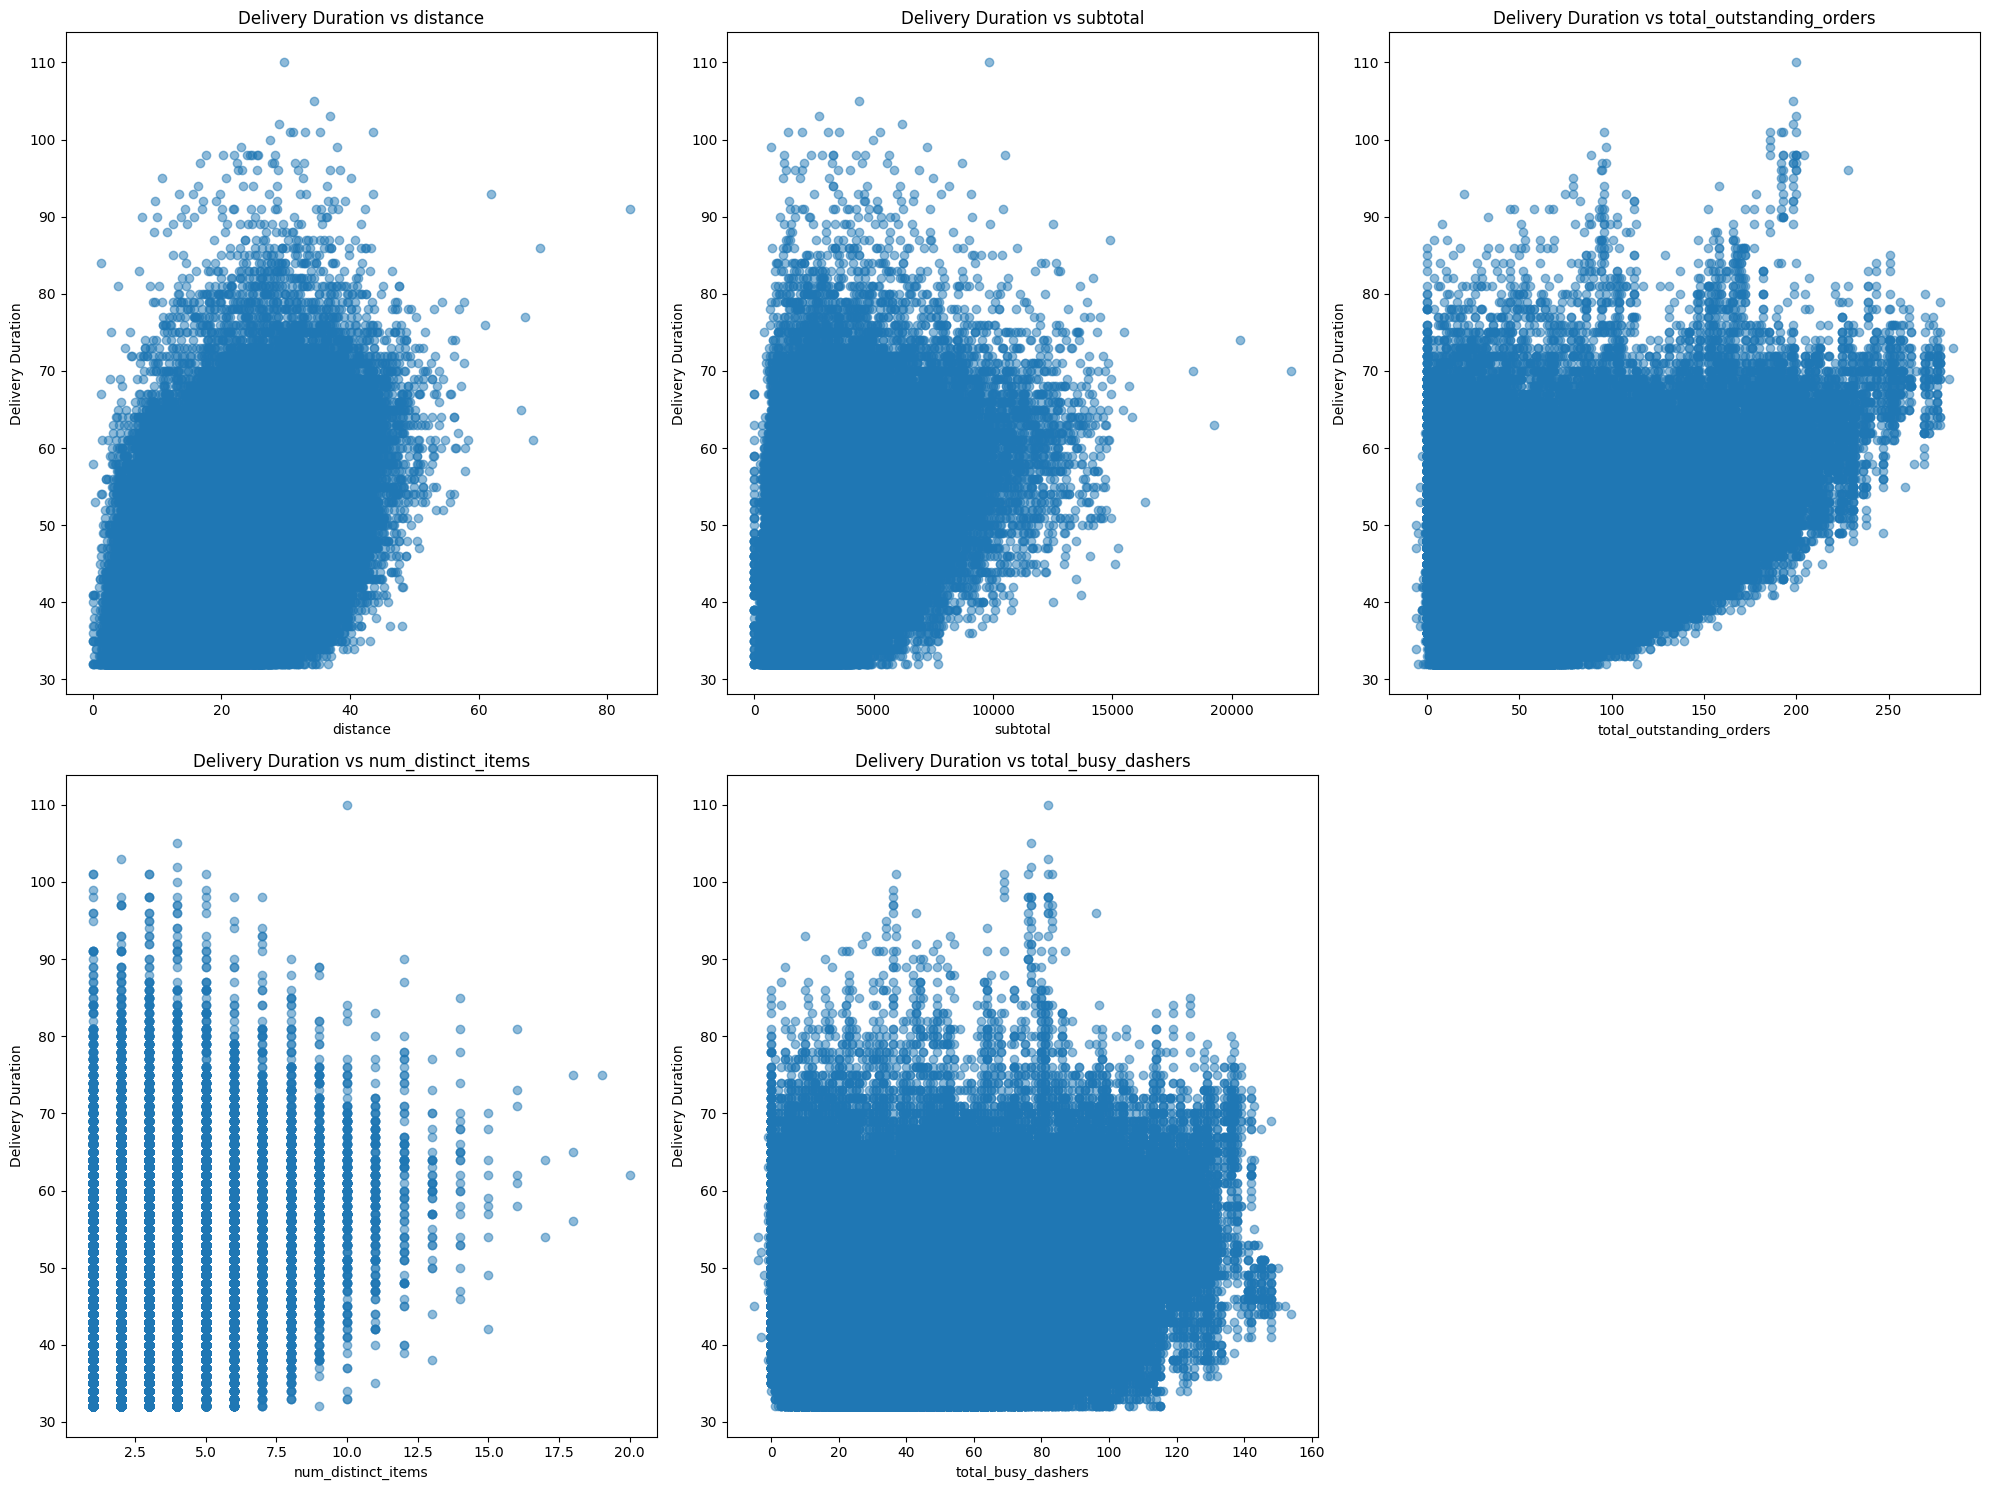

In [16]:
# Scatter plot to visualise the relationship between time_taken and other features
plt.figure(figsize=(20, 15))

# Top correlated numerical features from earlier analysis
important_features = ['distance', 'subtotal', 'total_outstanding_orders', 
                     'num_distinct_items', 'total_busy_dashers']

# Create scatter plots
for idx, feature in enumerate(important_features, 1):
    plt.subplot(2, 3, idx)
    plt.scatter(X_train[feature], y_train, alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('Delivery Duration')
    plt.title(f'Delivery Duration vs {feature}')

plt.tight_layout()
plt.show()


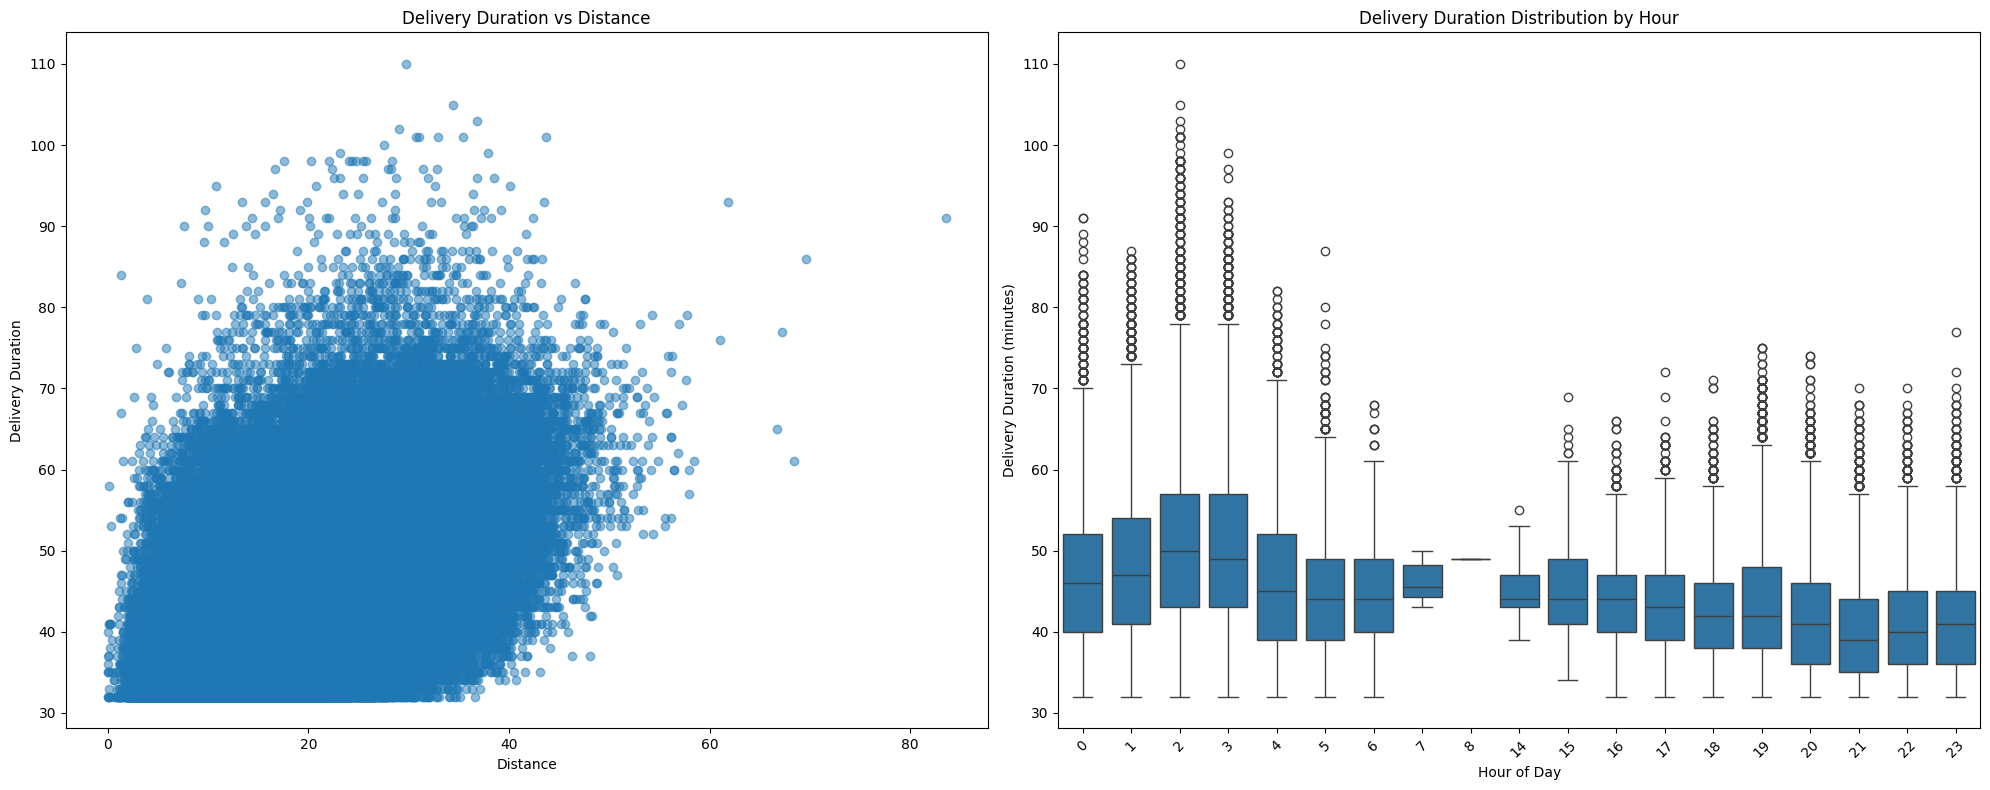


Delivery Duration Statistics by Hour:
      Average Duration  Count
hour                         
2            50.722906  26399
1            47.721858  20752
3            50.241796  19045
20           41.639307  11087
4            46.012300  10488
19           43.501989   9552
0            46.495657   9210
21           40.215908   8147
22           40.691794   6288
23           41.352329   5861
5            44.392107   4713
18           42.391641   3613
17           43.606664   2461
16           44.051489   1612
6            44.927521    952
15           45.392593    405
14           45.206897     29
7            46.166667      6
8            49.000000      1


In [17]:
# Show the distribution of time_taken for different hours
# Create a figure for both scatter plots and hour distribution
plt.figure(figsize=(20, 8))

# 1. Scatter plots for top correlated features
plt.subplot(1, 2, 1)
plt.scatter(X_train['distance'], y_train, alpha=0.5)
plt.xlabel('Distance')
plt.ylabel('Delivery Duration')
plt.title('Delivery Duration vs Distance')

# 2. Box plot of delivery duration by hour
plt.subplot(1, 2, 2)
sns.boxplot(x='hour', y=y_train, data=X_train)
plt.xlabel('Hour of Day')
plt.ylabel('Delivery Duration (minutes)')
plt.title('Delivery Duration Distribution by Hour')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print average delivery duration by hour
hour_stats = pd.DataFrame({
    'Average Duration': y_train.groupby(X_train['hour']).mean(),
    'Count': y_train.groupby(X_train['hour']).count()
})
print("\nDelivery Duration Statistics by Hour:")
print(hour_stats.sort_values('Count', ascending=False))


#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

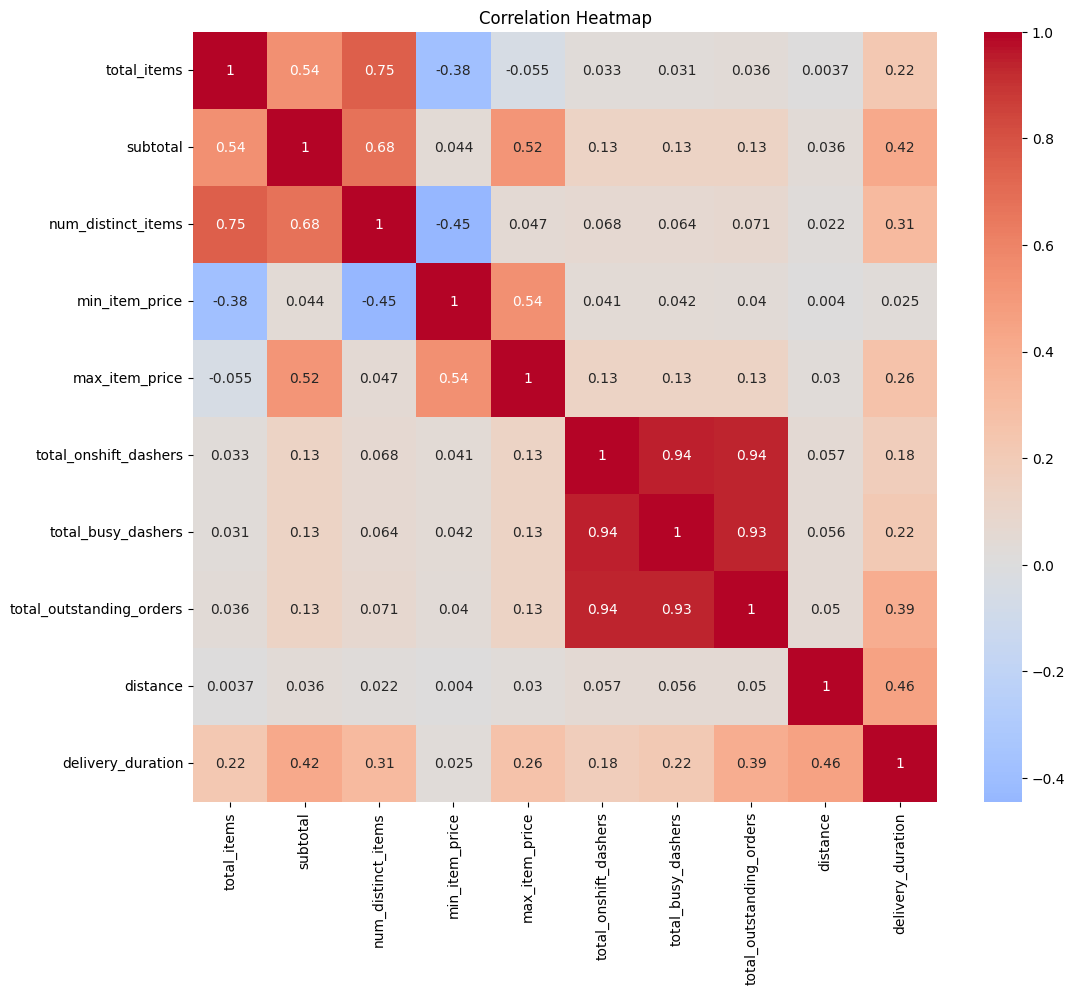

In [18]:
# Plot the heatmap of the correlation matrix
numerical_features = ['total_items', 'subtotal', 'num_distinct_items', 
                     'min_item_price', 'max_item_price', 'total_onshift_dashers',
                     'total_busy_dashers', 'total_outstanding_orders', 'distance']

# Create correlation matrix including target variable
corr_data = pd.concat([X_train[numerical_features], y_train], axis=1)
correlation_matrix = corr_data.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()


##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [19]:
# Drop 3-5 weakly correlated columns from training dataset
correlations_with_target = abs(correlation_matrix['delivery_duration']).sort_values(ascending=False)
print("\nCorrelations with delivery duration:")
print(correlations_with_target)

# Identify weakly correlated features (correlation < 0.2)
weak_correlations = correlations_with_target[correlations_with_target < 0.2]
print("\nWeakly correlated features to be dropped:")
print(weak_correlations)



Correlations with delivery duration:
delivery_duration           1.000000
distance                    0.456982
subtotal                    0.417949
total_outstanding_orders    0.394619
num_distinct_items          0.313696
max_item_price              0.261772
total_items                 0.221221
total_busy_dashers          0.217557
total_onshift_dashers       0.180989
min_item_price              0.024801
Name: delivery_duration, dtype: float64

Weakly correlated features to be dropped:
total_onshift_dashers    0.180989
min_item_price           0.024801
Name: delivery_duration, dtype: float64


#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

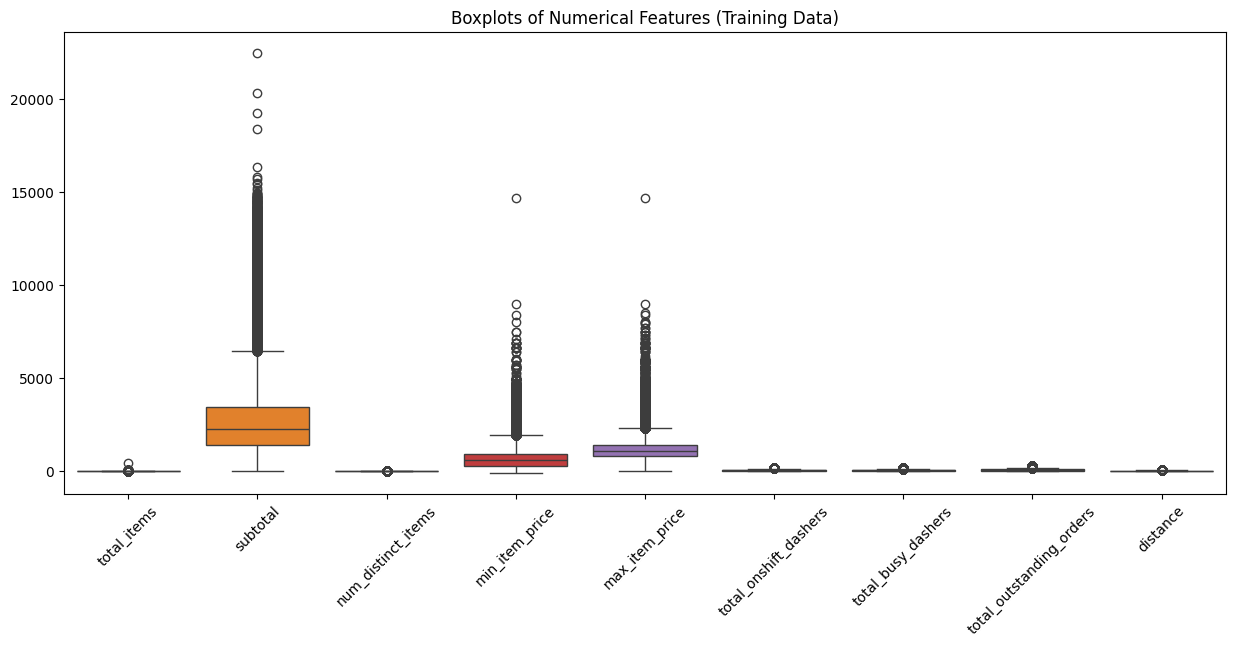

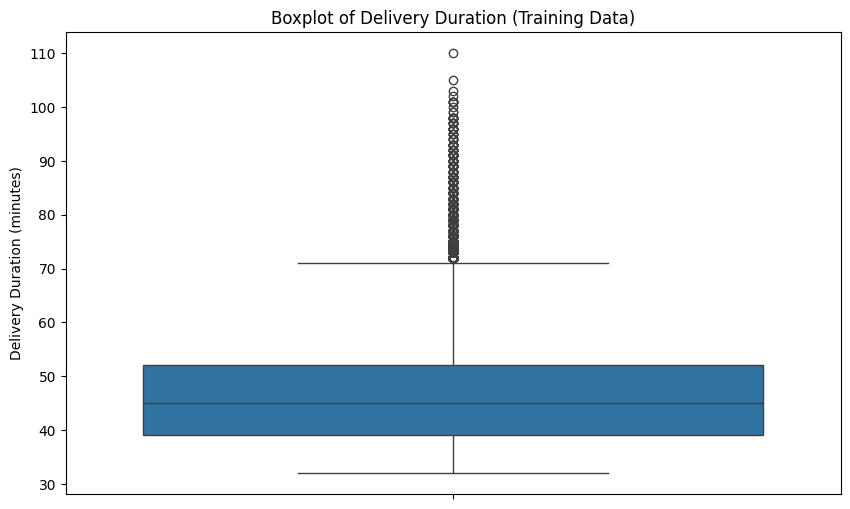

In [20]:
# Boxplot for time_taken
plt.figure(figsize=(15, 6))
sns.boxplot(data=X_train[numerical_features])
plt.xticks(rotation=45)
plt.title('Boxplots of Numerical Features (Training Data)')
plt.show()

# Boxplot for target variable
plt.figure(figsize=(10, 6))
sns.boxplot(y=y_train)
plt.title('Boxplot of Delivery Duration (Training Data)')
plt.ylabel('Delivery Duration (minutes)')
plt.show()


##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [21]:

def analyze_outliers_detailed(data, columns):
    outlier_stats = {}
    
    for column in columns:
        # Calculate statistics
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)][column]
        lower_outliers = data[data[column] < lower_bound][column]
        upper_outliers = data[data[column] > upper_bound][column]
        
        outlier_stats[column] = {
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'total_outliers': len(outliers),
            'lower_outliers': len(lower_outliers),
            'upper_outliers': len(upper_outliers),
            'percentage_outliers': (len(outliers) / len(data)) * 100,
            'min_value': data[column].min(),
            'max_value': data[column].max()
        }
    
    return pd.DataFrame(outlier_stats).T

# Analyze outliers in numerical features
print("Detailed Outlier Analysis for Numerical Features:")
numerical_features = ['total_items', 'subtotal', 'num_distinct_items', 
                     'min_item_price', 'max_item_price', 'total_onshift_dashers',
                     'total_busy_dashers', 'total_outstanding_orders', 'distance']

outlier_analysis = analyze_outliers_detailed(X_train, numerical_features)
print("\nOutlier Statistics:")
print(outlier_analysis.round(2))

# Analyze outliers in target variable
print("\nDetailed Outlier Analysis for Delivery Duration:")
target_analysis = analyze_outliers_detailed(pd.DataFrame(y_train, columns=['delivery_duration']), 
                                          ['delivery_duration'])
print(target_analysis.round(2))


Detailed Outlier Analysis for Numerical Features:

Outlier Statistics:
                               Q1       Q3      IQR  lower_bound  upper_bound  \
total_items                  2.00     4.00     2.00        -1.00         7.00   
subtotal                  1420.00  3440.00  2020.00     -1610.00      6470.00   
num_distinct_items           2.00     3.00     1.00         0.50         4.50   
min_item_price             299.00   945.00   646.00      -670.00      1914.00   
max_item_price             799.00  1399.00   600.00      -101.00      2299.00   
total_onshift_dashers       17.00    66.00    49.00       -56.50       139.50   
total_busy_dashers          15.00    63.00    48.00       -57.00       135.00   
total_outstanding_orders    17.00    86.00    69.00       -86.50       189.50   
distance                    15.32    28.08    12.76        -3.82        47.22   

                          total_outliers  lower_outliers  upper_outliers  \
total_items                       6845.0  

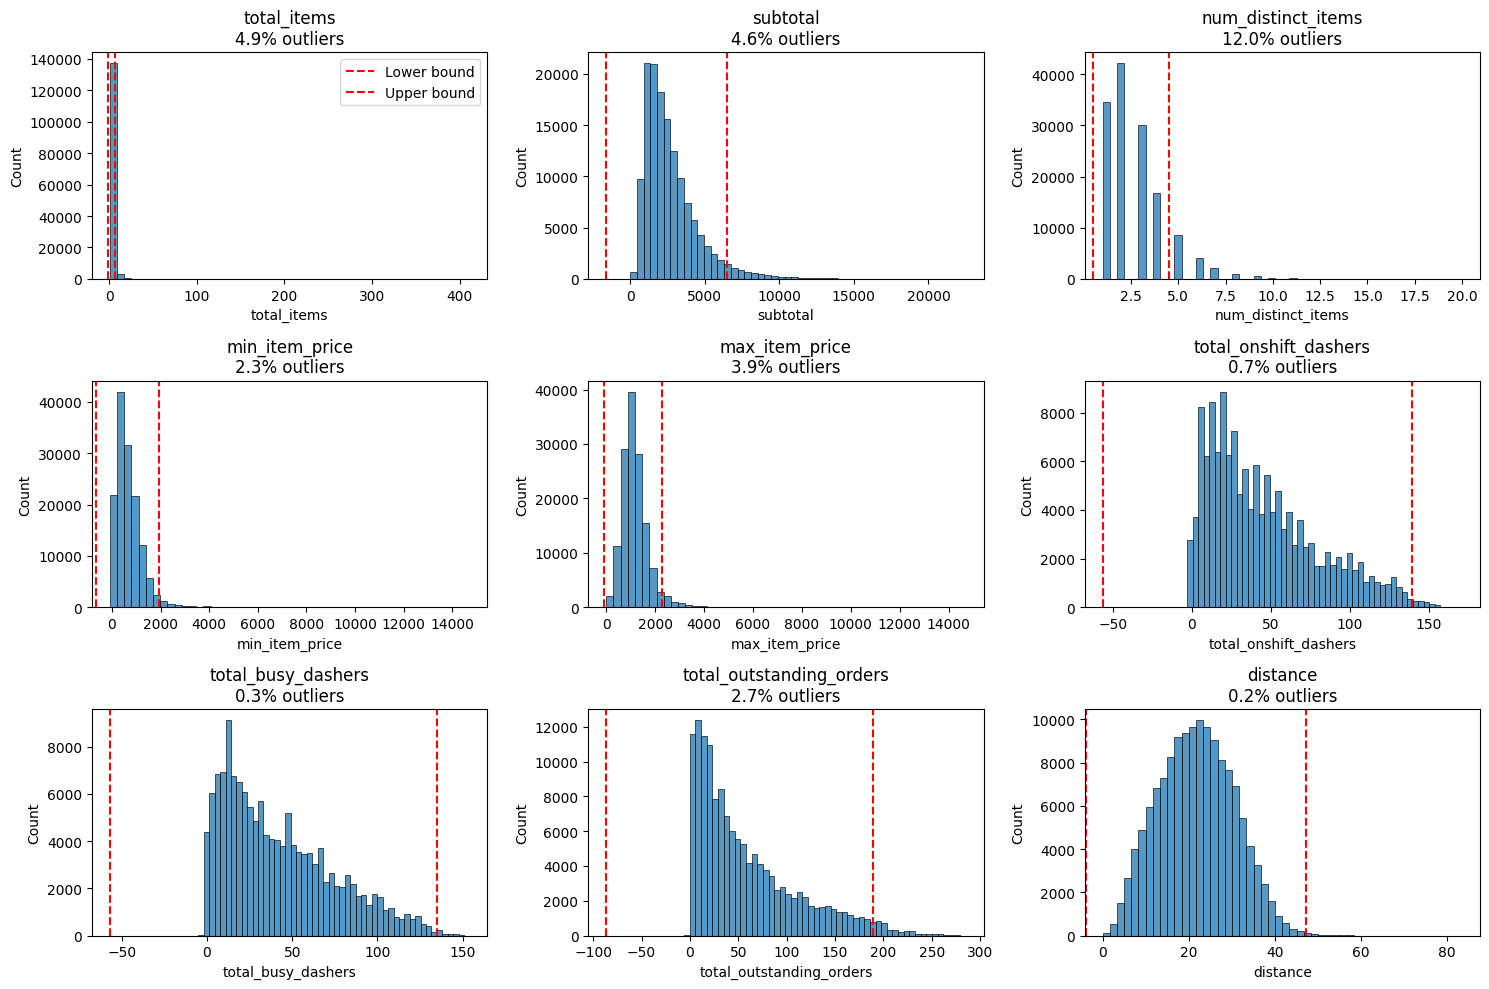

In [22]:

# Visualize outlier distribution for each feature
plt.figure(figsize=(15, 10))
for idx, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 3, idx)
    sns.histplot(data=X_train, x=feature, bins=50)
    plt.axvline(outlier_analysis.loc[feature, 'lower_bound'], color='r', linestyle='--', label='Lower bound')
    plt.axvline(outlier_analysis.loc[feature, 'upper_bound'], color='r', linestyle='--', label='Upper bound')
    if idx == 1:
        plt.legend()
    plt.title(f'{feature}\n{outlier_analysis.loc[feature, "percentage_outliers"]:.1f}% outliers')
plt.tight_layout()
plt.show()


In [23]:

# Print summary of findings
print("\nSummary of Findings:")
for feature in numerical_features:
    stats = outlier_analysis.loc[feature]
    print(f"\n{feature}:")
    print(f"- Total outliers: {stats['total_outliers']} ({stats['percentage_outliers']:.2f}%)")
    print(f"- Lower outliers: {stats['lower_outliers']} (below {stats['lower_bound']:.2f})")
    print(f"- Upper outliers: {stats['upper_outliers']} (above {stats['upper_bound']:.2f})")
    print(f"- Range: [{stats['min_value']:.2f}, {stats['max_value']:.2f}]")

# Analyze impact of outliers on delivery duration
print("\nAnalyzing relationship between outliers and delivery duration:")
for feature in numerical_features:
    # Calculate mean delivery duration for normal vs outlier values
    lower_bound = outlier_analysis.loc[feature, 'lower_bound']
    upper_bound = outlier_analysis.loc[feature, 'upper_bound']
    
    normal_duration = y_train[(X_train[feature] >= lower_bound) & 
                             (X_train[feature] <= upper_bound)].mean()
    outlier_duration = y_train[(X_train[feature] < lower_bound) | 
                              (X_train[feature] > upper_bound)].mean()
    
    print(f"\n{feature}:")
    print(f"- Mean delivery duration (normal values): {normal_duration:.2f}")
    print(f"- Mean delivery duration (outliers): {outlier_duration:.2f}")


Summary of Findings:

total_items:
- Total outliers: 6845.0 (4.87%)
- Lower outliers: 0.0 (below -1.00)
- Upper outliers: 6845.0 (above 7.00)
- Range: [1.00, 411.00]

subtotal:
- Total outliers: 6402.0 (4.55%)
- Lower outliers: 0.0 (below -1610.00)
- Upper outliers: 6402.0 (above 6470.00)
- Range: [0.00, 22500.00]

num_distinct_items:
- Total outliers: 16890.0 (12.01%)
- Lower outliers: 0.0 (below 0.50)
- Upper outliers: 16890.0 (above 4.50)
- Range: [1.00, 20.00]

min_item_price:
- Total outliers: 3299.0 (2.35%)
- Lower outliers: 0.0 (below -670.00)
- Upper outliers: 3299.0 (above 1914.00)
- Range: [-86.00, 14700.00]

max_item_price:
- Total outliers: 5445.0 (3.87%)
- Lower outliers: 0.0 (below -101.00)
- Upper outliers: 5445.0 (above 2299.00)
- Range: [0.00, 14700.00]

total_onshift_dashers:
- Total outliers: 976.0 (0.69%)
- Lower outliers: 0.0 (below -56.50)
- Upper outliers: 976.0 (above 139.50)
- Range: [-3.00, 171.00]

total_busy_dashers:
- Total outliers: 385.0 (0.27%)
- Lower 

In [24]:
def handle_outliers(data, columns):
    data_clean = data.copy()
    
    for column in columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        
        if column == 'subtotal':
            # Use 2.5 IQR for subtotal to be less aggressive
            lower_bound = Q1 - 2.5 * IQR
            upper_bound = Q3 + 2.5 * IQR
        else:
            # Keep 1.5 IQR for other features
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
        
        # Apply clipping only to high-impact features
        if column in ['distance', 'total_outstanding_orders', 
                     'total_busy_dashers', 'subtotal']:
            data_clean[column] = data_clean[column].clip(lower_bound, upper_bound)
    
    return data_clean

# Apply updated outlier handling
X_train_cleaned = handle_outliers(X_train, numerical_features)

# Verify the impact
for feature in ['distance', 'total_outstanding_orders', 'total_busy_dashers', 'subtotal']:
    print(f"\nComparing {feature} before and after handling outliers:")
    print("Before:")
    print(X_train[feature].describe())
    print("\nAfter:")
    print(X_train_cleaned[feature].describe())




Comparing distance before and after handling outliers:
Before:
count    140621.000000
mean         21.806671
std           8.750412
min           0.000000
25%          15.320000
50%          21.720000
75%          28.080000
max          83.520000
Name: distance, dtype: float64

After:
count    140621.000000
mean         21.800569
std           8.729701
min           0.000000
25%          15.320000
50%          21.720000
75%          28.080000
max          47.220000
Name: distance, dtype: float64

Comparing total_outstanding_orders before and after handling outliers:
Before:
count    140621.000000
mean         58.446391
std          52.951764
min          -6.000000
25%          17.000000
50%          41.000000
75%          86.000000
max         285.000000
Name: total_outstanding_orders, dtype: float64

After:
count    140621.000000
mean         57.832433
std          51.152840
min          -6.000000
25%          17.000000
50%          41.000000
75%          86.000000
max         189.50

In [25]:
# Check boundary values with updated approach
def check_boundary_values(data_original, data_cleaned, feature):
    # Calculate bounds based on feature
    Q1 = data_original[feature].quantile(0.25)
    Q3 = data_original[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    if feature == 'subtotal':
        lower_bound = Q1 - 2.5 * IQR
        upper_bound = Q3 + 2.5 * IQR
    else:
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
    
    # Count values at boundaries
    at_lower = (data_cleaned[feature] == lower_bound).sum()
    at_upper = (data_cleaned[feature] == upper_bound).sum()
    
    print(f"\n{feature}:")
    print(f"Values at lower bound ({lower_bound:.2f}): {at_lower}")
    print(f"Values at upper bound ({upper_bound:.2f}): {at_upper}")
    print(f"Total boundary values: {at_lower + at_upper}")
    print(f"Percentage of data at boundaries: {((at_lower + at_upper) / len(data_cleaned)) * 100:.2f}%")

# Check boundary values for all handled features
for feature in ['distance', 'total_outstanding_orders', 'total_busy_dashers', 'subtotal']:
    check_boundary_values(X_train, X_train_cleaned, feature)


distance:
Values at lower bound (-3.82): 0
Values at upper bound (47.22): 258
Total boundary values: 258
Percentage of data at boundaries: 0.18%

total_outstanding_orders:
Values at lower bound (-86.50): 0
Values at upper bound (189.50): 3809
Total boundary values: 3809
Percentage of data at boundaries: 2.71%

total_busy_dashers:
Values at lower bound (-57.00): 0
Values at upper bound (135.00): 425
Total boundary values: 425
Percentage of data at boundaries: 0.30%

subtotal:
Values at lower bound (-3630.00): 0
Values at upper bound (8490.00): 2330
Total boundary values: 2330
Percentage of data at boundaries: 1.66%


## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [26]:
# Define numerical and categorical columns for easy EDA and data manipulation



In [43]:
# Compare numerical distributions between train and test
def compare_train_test_distributions(train_data, test_data, numerical_features):
    print("Comparing Training vs Test Set Statistics:")
    for feature in numerical_features:
        print(f"\n{feature}:")
        
        # Create comparison dataframe
        comparison = pd.DataFrame({
            'Training': train_data[feature].describe(),
            'Test': test_data[feature].describe()
        })
        print(comparison)

# Compare target variable distribution
def compare_target_distribution(y_train, y_test):
    print("\nDelivery Duration Statistics:")
    comparison = pd.DataFrame({
        'Training': y_train.describe(),
        'Test': y_test.describe()
    })
    print(comparison)

# Compare categorical distributions
def compare_categorical_distributions(train_data, test_data):
    print("\nCategorical Features Distribution (%):")
    
    # Market ID distribution
    market_cols = [col for col in train_data.columns if col.startswith('market_id')]
    for col in market_cols:
        train_pct = train_data[col].mean() * 100
        test_pct = test_data[col].mean() * 100
        print(f"\n{col}:")
        print(f"Training: {train_pct:.2f}%")
        print(f"Test: {test_pct:.2f}%")

# Run the comparisons
numerical_features = ['total_items', 'subtotal', 'num_distinct_items', 
                     'min_item_price', 'max_item_price', 'total_onshift_dashers',
                     'total_busy_dashers', 'total_outstanding_orders', 'distance']

compare_train_test_distributions(X_train, X_test, numerical_features)
compare_target_distribution(y_train, y_test)
compare_categorical_distributions(X_train, X_test)

Comparing Training vs Test Set Statistics:

total_items:
            Training          Test
count  140621.000000  35156.000000
mean        3.224362      3.127432
std         2.725034      2.458109
min         1.000000      1.000000
25%         2.000000      2.000000
50%         3.000000      3.000000
75%         4.000000      4.000000
max       411.000000     66.000000

subtotal:
            Training          Test
count  140621.000000  35156.000000
mean     2710.801409   2642.351263
std      1836.203556   1796.618396
min         0.000000      0.000000
25%      1420.000000   1398.000000
50%      2242.000000   2187.000000
75%      3440.000000   3345.000000
max     22500.000000  26800.000000

num_distinct_items:
            Training          Test
count  140621.000000  35156.000000
mean        2.689364      2.617846
std         1.631560      1.600693
min         1.000000      1.000000
25%         2.000000      1.000000
50%         2.000000      2.000000
75%         3.000000      3.000000
m

In [45]:
# Apply the same outlier handling to test data
X_test_cleaned = handle_outliers(X_test, numerical_features)

# Verify the impact on test data
print("Impact of outlier handling on test data:")
for feature in ['distance', 'total_outstanding_orders', 'total_busy_dashers', 'subtotal']:
    print(f"\nComparing {feature} before and after handling outliers (Test Set):")
    print("Before:")
    print(X_test[feature].describe())
    print("\nAfter:")
    print(X_test_cleaned[feature].describe())

# Check boundary values in test set
for feature in ['distance', 'total_outstanding_orders', 'total_busy_dashers', 'subtotal']:
    check_boundary_values(X_test, X_test_cleaned, feature)

Impact of outlier handling on test data:

Comparing distance before and after handling outliers (Test Set):
Before:
count    35156.000000
mean        21.988762
std          8.740516
min          0.000000
25%         15.400000
50%         21.960000
75%         28.240000
max         56.480000
Name: distance, dtype: float64

After:
count    35156.000000
mean        21.985172
std          8.729152
min          0.000000
25%         15.400000
50%         21.960000
75%         28.240000
max         47.500000
Name: distance, dtype: float64

Comparing total_outstanding_orders before and after handling outliers (Test Set):
Before:
count    35156.000000
mean        57.365030
std         51.830504
min         -5.000000
25%         17.000000
50%         40.500000
75%         83.000000
max        278.000000
Name: total_outstanding_orders, dtype: float64

After:
count    35156.000000
mean        56.596029
std         49.625198
min         -5.000000
25%         17.000000
50%         40.500000
75%     

<b>The data is consistent for both train and test data

#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

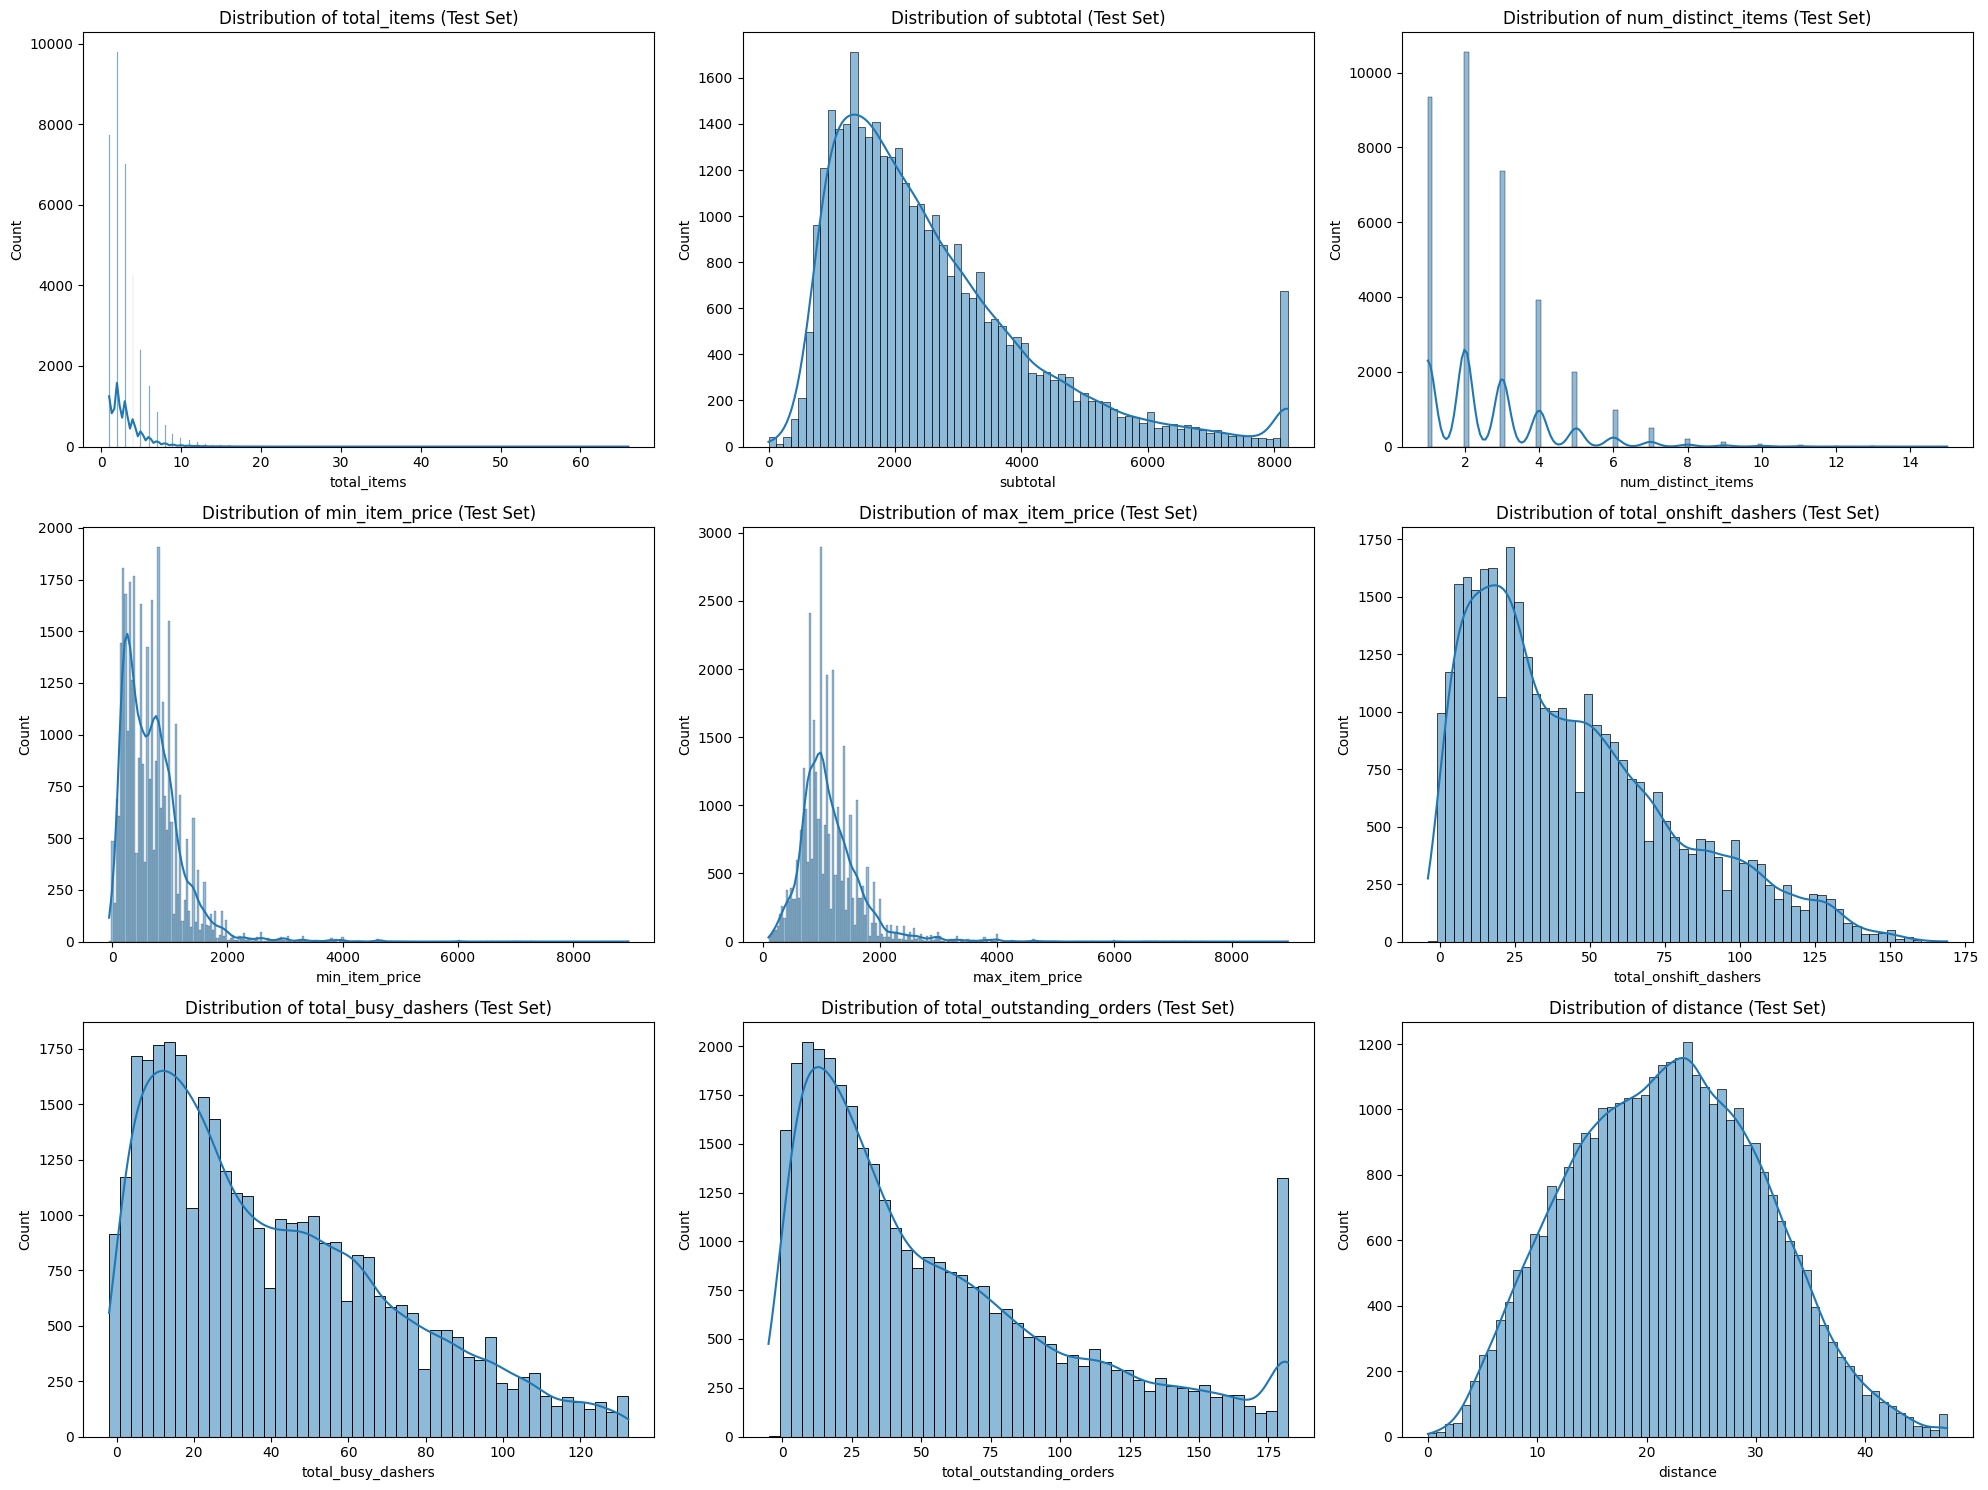

In [46]:
# Plot distributions for all numerical columns
plt.figure(figsize=(20, 15))
numerical_features = ['total_items', 'subtotal', 'num_distinct_items', 
                     'min_item_price', 'max_item_price', 'total_onshift_dashers',
                     'total_busy_dashers', 'total_outstanding_orders', 'distance']

for idx, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 3, idx)
    sns.histplot(data=X_test_cleaned[feature], kde=True)
    plt.title(f'Distribution of {feature} (Test Set)')
    plt.xlabel(feature)
plt.tight_layout()
plt.show()


##### **4.1.2**
Check the distribution of categorical features

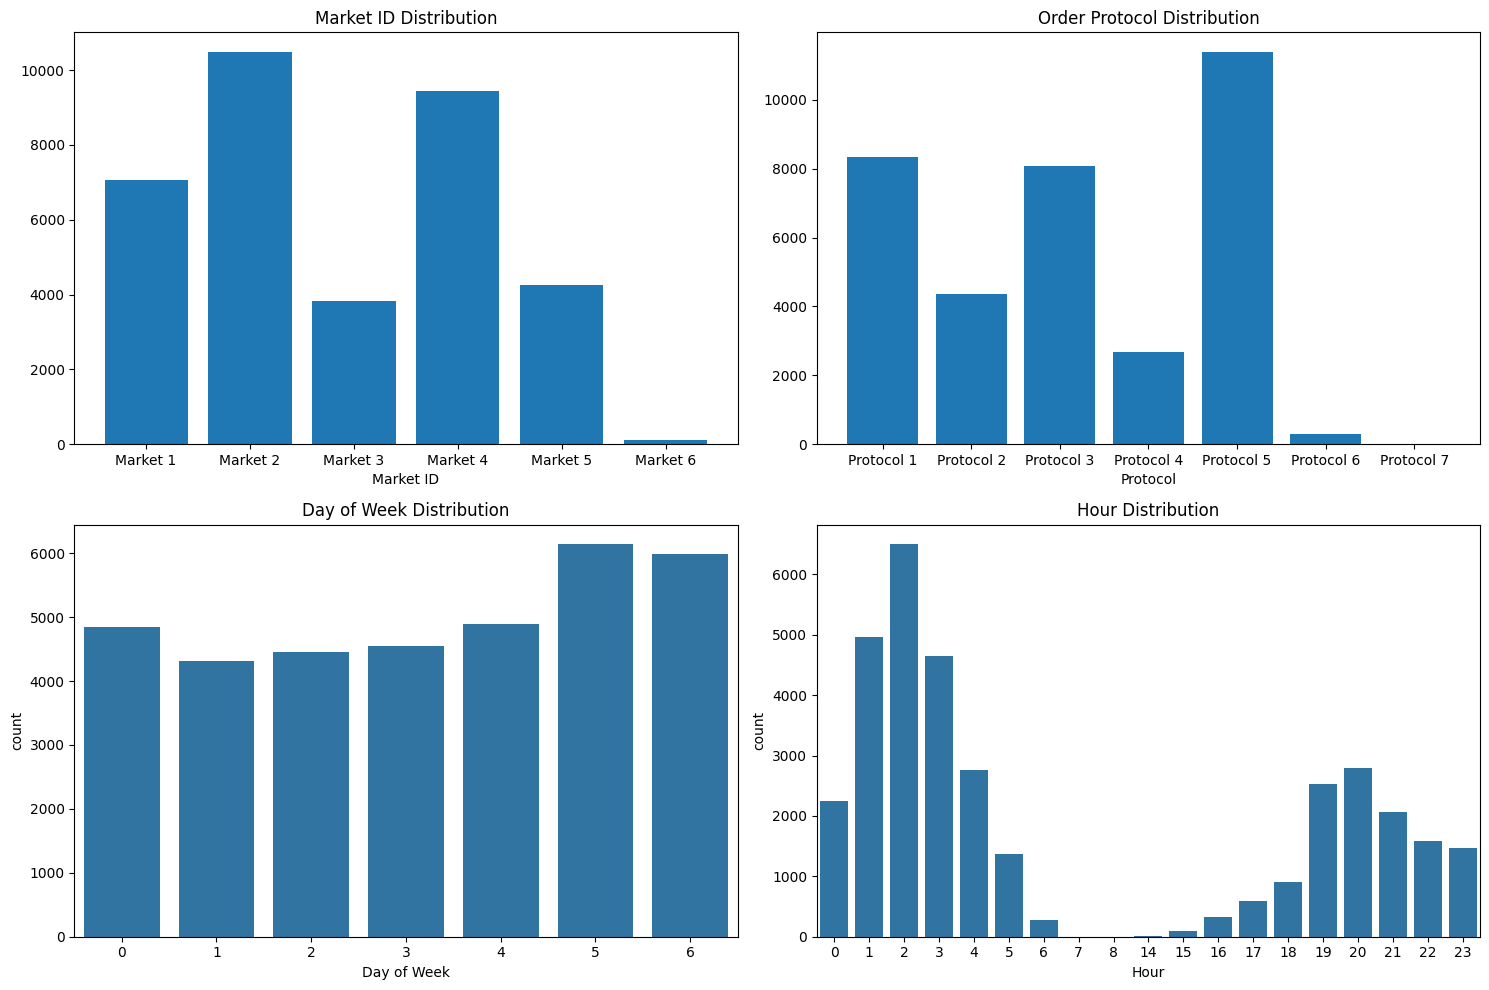

In [50]:
# Distribution of categorical columns
plt.figure(figsize=(15, 10))

# Market ID distribution
plt.subplot(2, 2, 1)
market_cols = [col for col in X_test.columns if col.startswith('market_id')]
market_dist = X_test[market_cols].sum()
plt.bar(range(len(market_dist)), market_dist)
plt.title('Market ID Distribution')
plt.xlabel('Market ID')
plt.xticks(range(len(market_dist)), [f'Market {i+1}' for i in range(len(market_dist))])

# Order Protocol distribution
plt.subplot(2, 2, 2)
protocol_cols = [col for col in X_test.columns if col.startswith('order_protocol')]
protocol_dist = X_test[protocol_cols].sum()
plt.bar(range(len(protocol_dist)), protocol_dist)
plt.title('Order Protocol Distribution')
plt.xlabel('Protocol')
plt.xticks(range(len(protocol_dist)), [f'Protocol {i+1}' for i in range(len(protocol_dist))])

# Day of Week distribution
plt.subplot(2, 2, 3)
sns.countplot(data=X_test, x='day_of_week')
plt.title('Day of Week Distribution')
plt.xlabel('Day of Week')

# Hour distribution
plt.subplot(2, 2, 4)
sns.countplot(data=X_test, x='hour')
plt.title('Hour Distribution')
plt.xlabel('Hour')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


In [48]:
print("\nMarket ID Distribution (%):")
market_dist_pct = (X_test[market_cols].sum() / len(X_test) * 100).round(2)
print(market_dist_pct)

print("\nOrder Protocol Distribution (%):")
protocol_dist_pct = (X_test[protocol_cols].sum() / len(X_test) * 100).round(2)
print(protocol_dist_pct)

print("\nDay of Week Distribution (%):")
day_dist_pct = (X_test['day_of_week'].value_counts() / len(X_test) * 100).round(2)
print(day_dist_pct.sort_index())


Market ID Distribution (%):
market_id_1.0    20.07
market_id_2.0    29.82
market_id_3.0    10.89
market_id_4.0    26.82
market_id_5.0    12.07
market_id_6.0     0.32
dtype: float64

Order Protocol Distribution (%):
order_protocol_1.0    23.75
order_protocol_2.0    12.40
order_protocol_3.0    22.98
order_protocol_4.0     7.63
order_protocol_5.0    32.40
order_protocol_6.0     0.84
order_protocol_7.0     0.00
dtype: float64

Day of Week Distribution (%):
day_of_week
0    13.77
1    12.27
2    12.66
3    12.92
4    13.93
5    17.45
6    17.01
Name: count, dtype: float64


##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

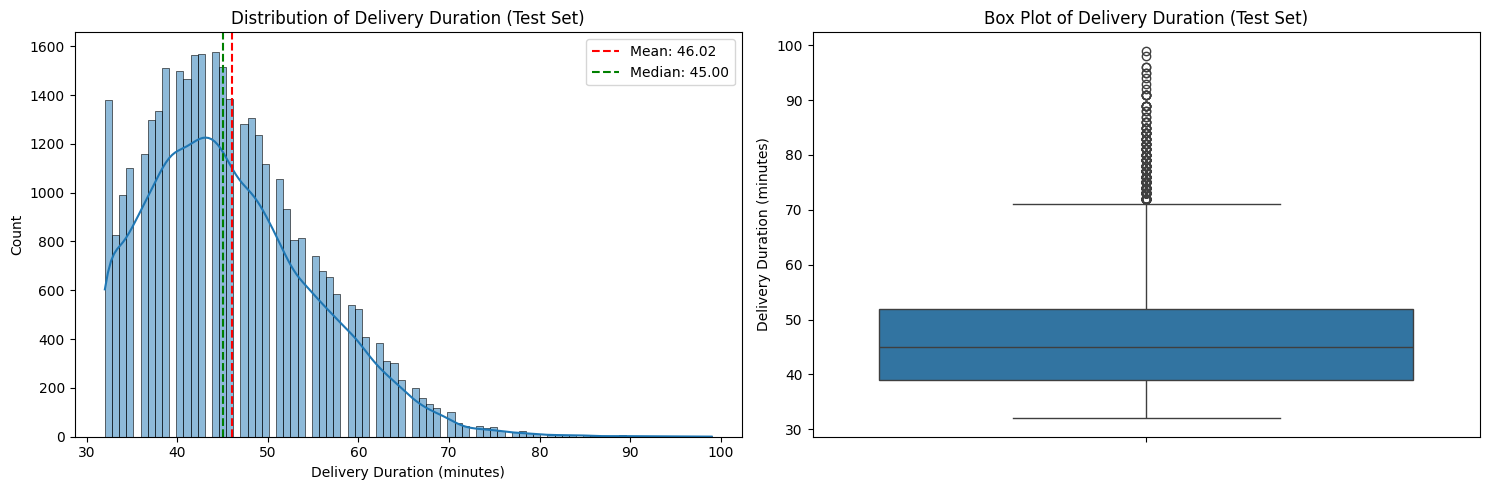

Delivery Duration Statistics (Test Set):
Count: 35156.00
Mean: 46.02
Median: 45.00
Std Dev: 9.28
Skewness: 0.74
Kurtosis: 0.50
Min: 32.00
Max: 99.00
25th Percentile: 39.00
75th Percentile: 52.00
IQR: 13.00

Delivery Duration Ranges:
0-35 mins: 9.09%
35-40 mins: 18.20%
40-45 mins: 21.83%
45-50 mins: 19.11%
50-55 mins: 13.45%
55-60 mins: 9.11%
60+ mins: 9.21%


In [51]:
# Distribution of time_taken
# 4.1.3 Visualize target variable distribution
plt.figure(figsize=(15, 5))

# Histogram with KDE
plt.subplot(1, 2, 1)
sns.histplot(data=y_test, kde=True)
plt.axvline(y_test.mean(), color='red', linestyle='--', label=f'Mean: {y_test.mean():.2f}')
plt.axvline(y_test.median(), color='green', linestyle='--', label=f'Median: {y_test.median():.2f}')
plt.title('Distribution of Delivery Duration (Test Set)')
plt.xlabel('Delivery Duration (minutes)')
plt.ylabel('Count')
plt.legend()

# Box plot
plt.subplot(1, 2, 2)
sns.boxplot(y=y_test)
plt.title('Box Plot of Delivery Duration (Test Set)')
plt.ylabel('Delivery Duration (minutes)')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("Delivery Duration Statistics (Test Set):")
stats = {
    'Count': len(y_test),
    'Mean': y_test.mean(),
    'Median': y_test.median(),
    'Std Dev': y_test.std(),
    'Skewness': y_test.skew(),
    'Kurtosis': y_test.kurtosis(),
    'Min': y_test.min(),
    'Max': y_test.max(),
    '25th Percentile': y_test.quantile(0.25),
    '75th Percentile': y_test.quantile(0.75),
    'IQR': y_test.quantile(0.75) - y_test.quantile(0.25)
}

for stat, value in stats.items():
    print(f"{stat}: {value:.2f}")

# Calculate percentage of deliveries in different time ranges
ranges = [
    (0, 35, '0-35 mins'),
    (35, 40, '35-40 mins'),
    (40, 45, '40-45 mins'),
    (45, 50, '45-50 mins'),
    (50, 55, '50-55 mins'),
    (55, 60, '55-60 mins'),
    (60, float('inf'), '60+ mins')
]

print("\nDelivery Duration Ranges:")
for start, end, label in ranges:
    pct = ((y_test >= start) & (y_test < end)).mean() * 100
    print(f"{label}: {pct:.2f}%")


#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

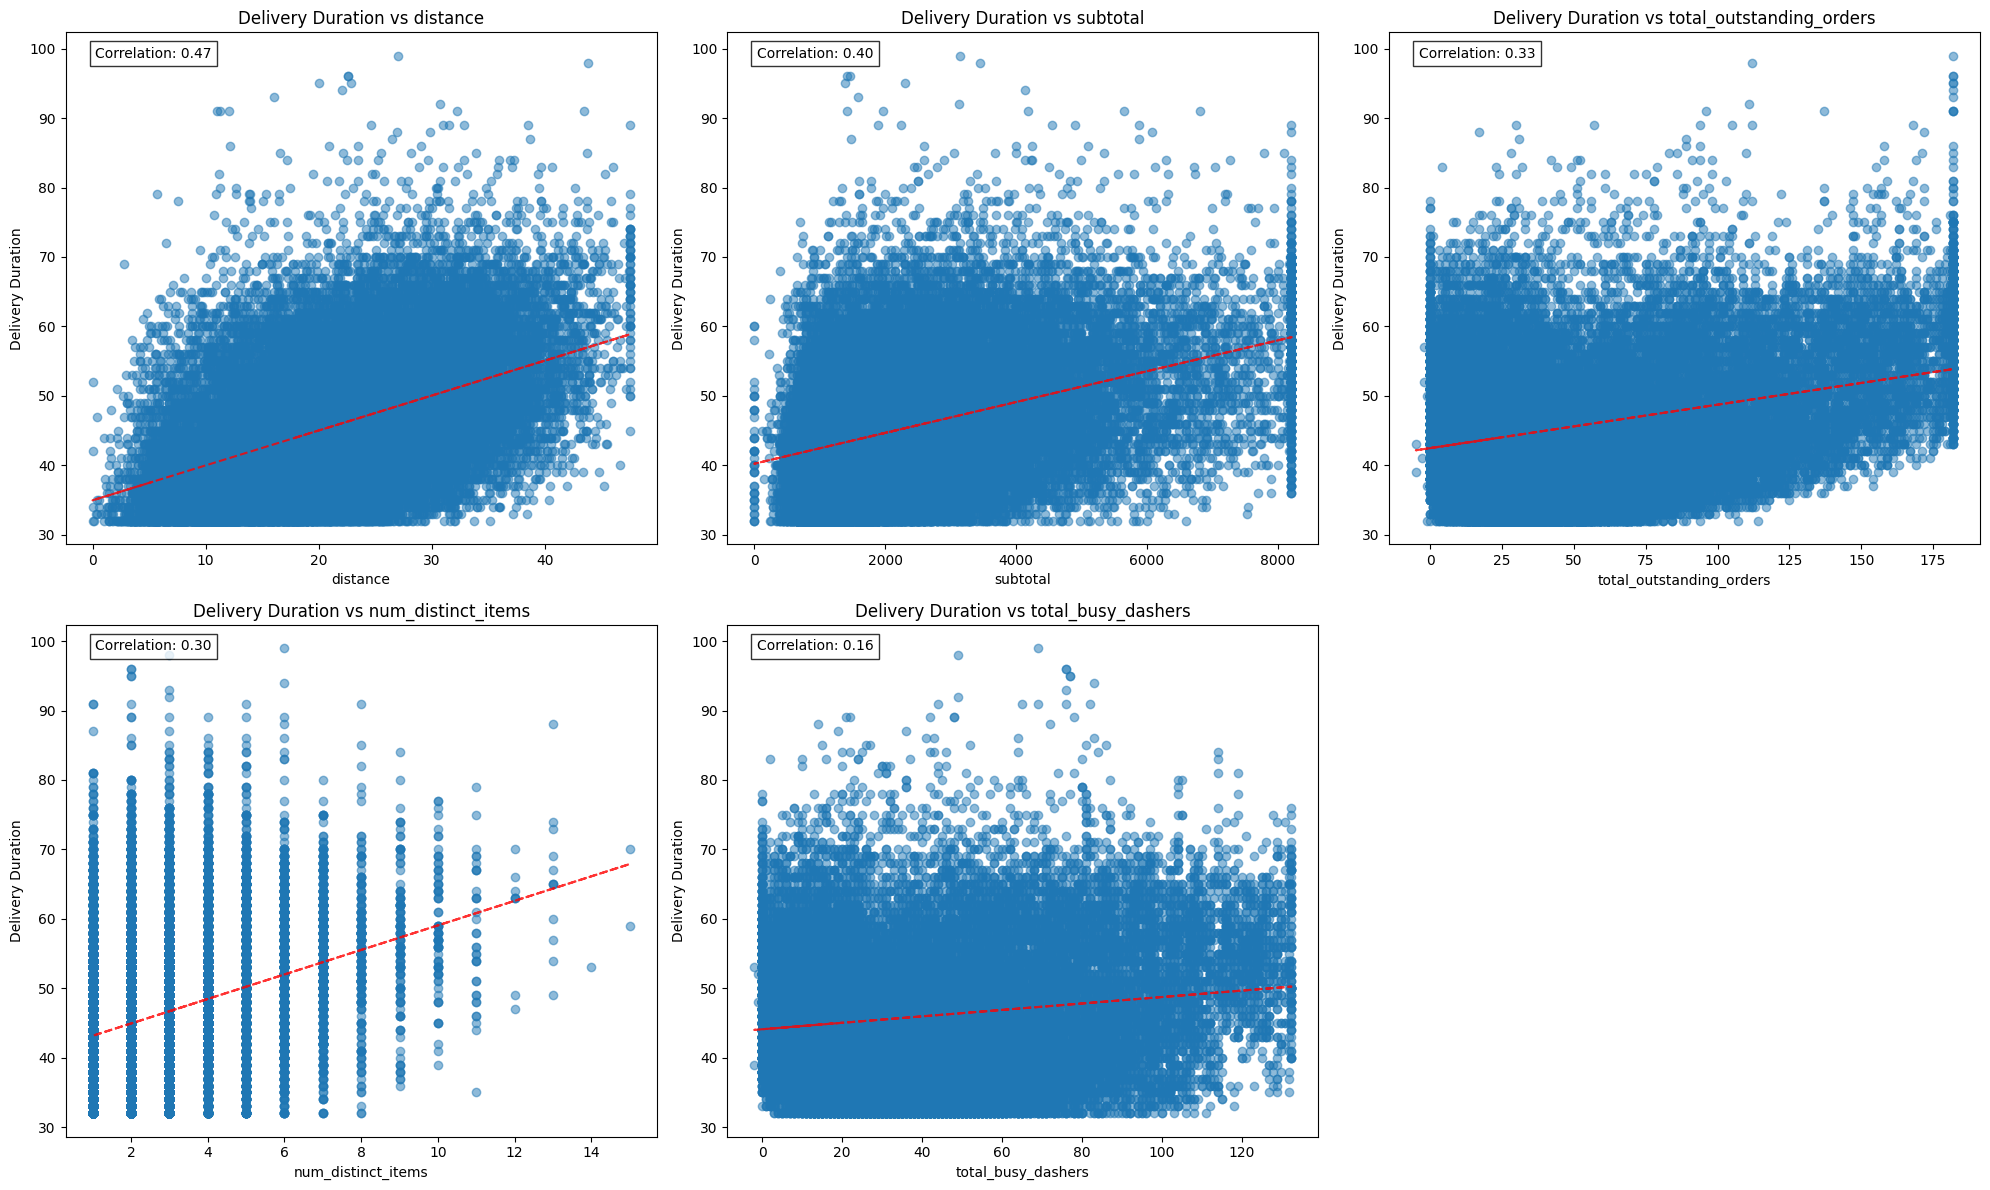


Correlations with Delivery Duration (Test Set):
                    Feature  Correlation
0                  distance        0.473
1                  subtotal        0.397
2  total_outstanding_orders        0.334
3        num_distinct_items        0.305
4        total_busy_dashers        0.159


In [52]:
# Scatter plot to visualise the relationship between time_taken and other features
important_features = ['distance', 'subtotal', 'total_outstanding_orders', 
                     'num_distinct_items', 'total_busy_dashers']

plt.figure(figsize=(20, 12))

# Create scatter plots for important features
for idx, feature in enumerate(important_features, 1):
    plt.subplot(2, 3, idx)
    plt.scatter(X_test_cleaned[feature], y_test, alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('Delivery Duration')
    plt.title(f'Delivery Duration vs {feature}')
    
    # Add trend line
    z = np.polyfit(X_test_cleaned[feature], y_test, 1)
    p = np.poly1d(z)
    plt.plot(X_test_cleaned[feature], p(X_test_cleaned[feature]), "r--", alpha=0.8)
    
    # Add correlation coefficient
    corr = X_test_cleaned[feature].corr(y_test)
    plt.text(0.05, 0.95, f'Correlation: {corr:.2f}', 
             transform=plt.gca().transAxes, 
             bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print correlations with target
correlations = []
for feature in important_features:
    corr = X_test_cleaned[feature].corr(y_test)
    correlations.append({'Feature': feature, 'Correlation': corr})

print("\nCorrelations with Delivery Duration (Test Set):")
corr_df = pd.DataFrame(correlations).sort_values('Correlation', ascending=False)
print(corr_df.round(3))


#### **4.3** Drop the columns with weak correlations with the target variable

In [53]:
# Drop the weakly correlated columns from training dataset
def drop_weak_correlations(X_train, X_test, threshold=0.2):
    # Calculate correlations with target for numerical features
    correlations = []
    numerical_features = ['total_items', 'subtotal', 'num_distinct_items', 
                         'min_item_price', 'max_item_price', 'total_onshift_dashers',
                         'total_busy_dashers', 'total_outstanding_orders', 'distance']
    
    for feature in numerical_features:
        corr = abs(X_train[feature].corr(y_train))
        correlations.append({'Feature': feature, 'Correlation': corr})
    
    # Identify features to drop
    corr_df = pd.DataFrame(correlations)
    weak_features = corr_df[corr_df['Correlation'] < threshold]['Feature'].tolist()
    
    print(f"Features with correlation < {threshold}:")
    print(corr_df[corr_df['Correlation'] < threshold])
    
    # Drop weak features from both train and test sets
    X_train_filtered = X_train.drop(columns=weak_features)
    X_test_filtered = X_test.drop(columns=weak_features)
    
    print(f"\nDropped {len(weak_features)} features: {weak_features}")
    print(f"Remaining features: {len(X_train_filtered.columns)}")
    
    return X_train_filtered, X_test_filtered

# Apply the function to our cleaned datasets
X_train_final, X_test_final = drop_weak_correlations(X_train_cleaned, X_test_cleaned)

# Verify the shapes of the final datasets
print("\nFinal dataset shapes:")
print(f"X_train: {X_train_final.shape}")
print(f"X_test: {X_test_final.shape}")


Features with correlation < 0.2:
                 Feature  Correlation
3         min_item_price     0.024801
5  total_onshift_dashers     0.180989

Dropped 2 features: ['min_item_price', 'total_onshift_dashers']
Remaining features: 97

Final dataset shapes:
X_train: (140621, 97)
X_test: (35156, 97)


## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [32]:
# Import libraries



#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [54]:
# Apply scaling to the numerical columns
def scale_features(X_train, X_test):
    # Identify numerical columns (excluding dummy variables)
    numerical_features = ['total_items', 'subtotal', 'num_distinct_items', 
                         'max_item_price', 'total_busy_dashers', 
                         'total_outstanding_orders', 'distance']
    
    # Initialize scaler
    scaler = StandardScaler()
    
    # Create copies to avoid modifying original data
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    
    # Fit scaler on training data and transform both train and test
    X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
    X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])
    
    # Print scaling results
    print("Scaling Results (Training Set):")
    print("\nBefore scaling:")
    print(X_train[numerical_features].describe().round(2))
    
    print("\nAfter scaling:")
    print(X_train_scaled[numerical_features].describe().round(2))
    
    return X_train_scaled, X_test_scaled, numerical_features

# Apply scaling
X_train_scaled, X_test_scaled, numerical_features = scale_features(X_train_final, X_test_final)


Scaling Results (Training Set):

Before scaling:
       total_items   subtotal  num_distinct_items  max_item_price  \
count    140621.00  140621.00           140621.00       140621.00   
mean          3.22    2680.36                2.69         1163.31   
std           2.73    1709.04                1.63          563.33   
min           1.00       0.00                1.00            0.00   
25%           2.00    1420.00                2.00          799.00   
50%           3.00    2242.00                2.00         1095.00   
75%           4.00    3440.00                3.00         1399.00   
max         411.00    8490.00               20.00        14700.00   

       total_busy_dashers  total_outstanding_orders   distance  
count           140621.00                 140621.00  140621.00  
mean                41.99                     57.83      21.80  
std                 32.21                     51.15       8.73  
min                 -5.00                     -6.00       0.00  
25% 

Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [55]:
# Create/Initialise the model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions on both train and test sets
y_train_pred = lr_model.predict(X_train_scaled)
y_test_pred = lr_model.predict(X_test_scaled)

In [57]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [62]:
# Calculate evaluation metrics
def calculate_metrics(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{dataset_name} Set Metrics:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R2) Score: {r2:.4f}")

# Calculate metrics for both sets
calculate_metrics(y_train, y_train_pred, "Training")
calculate_metrics(y_test, y_test_pred, "Test")

# Feature importance analysis
feature_importance = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': lr_model.coef_
})
feature_importance['Abs_Coefficient'] = abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

print("\nTop 12 Most Important Features:")
print(feature_importance.head(12))


Training Set Metrics:
Mean Squared Error (MSE): 20.1851
Root Mean Squared Error (RMSE): 4.4928
Mean Absolute Error (MAE): 3.3179
R-squared (R2) Score: 0.7686

Test Set Metrics:
Mean Squared Error (MSE): 20.7896
Root Mean Squared Error (RMSE): 4.5596
Mean Absolute Error (MAE): 3.3616
R-squared (R2) Score: 0.7586

Top 12 Most Important Features:
                      Feature  Coefficient  Abs_Coefficient
5    total_outstanding_orders    13.018712        13.018712
4          total_busy_dashers   -10.228227        10.228227
20   store_primary_category_3     6.833662         6.833662
38  store_primary_category_21    -4.852658         4.852658
10                 is_weekend     4.388019         4.388019
65  store_primary_category_48    -4.353291         4.353291
6                    distance     4.214499         4.214499
11              market_id_1.0     4.093646         4.093646
12              market_id_2.0    -2.466691         2.466691
81  store_primary_category_64     2.421477         2.

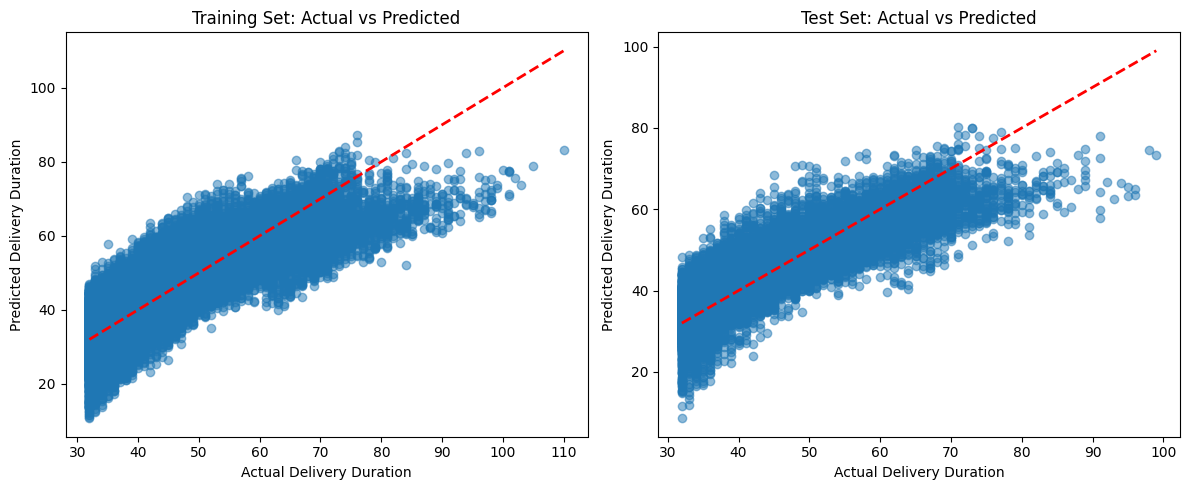

In [63]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 5))

# Training set
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual Delivery Duration')
plt.ylabel('Predicted Delivery Duration')
plt.title('Training Set: Actual vs Predicted')

# Test set
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Delivery Duration')
plt.ylabel('Predicted Delivery Duration')
plt.title('Test Set: Actual vs Predicted')

plt.tight_layout()
plt.show()


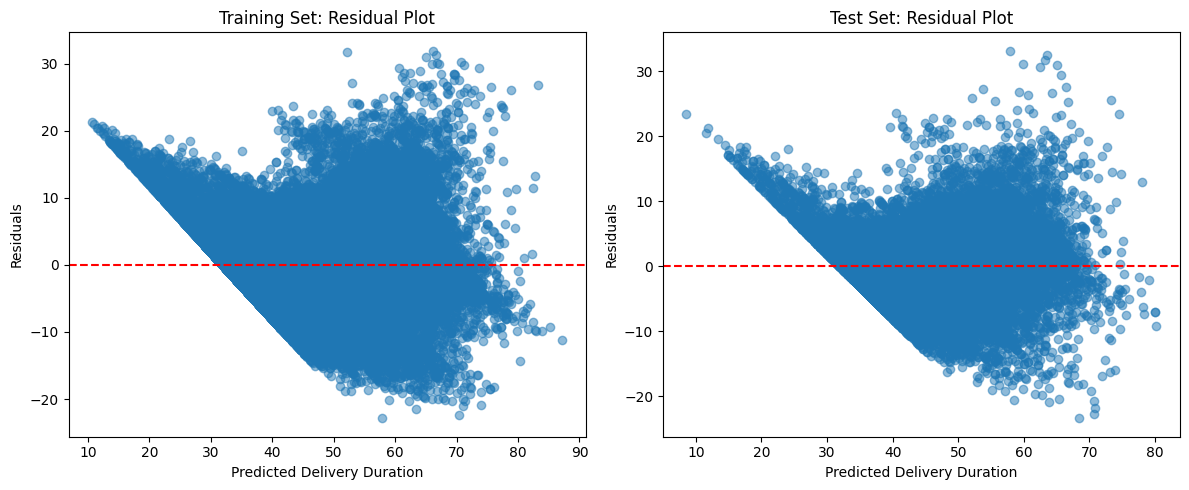

In [64]:
# Plot residuals
plt.figure(figsize=(12, 5))

# Training set residuals
plt.subplot(1, 2, 1)
residuals_train = y_train - y_train_pred
plt.scatter(y_train_pred, residuals_train, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Delivery Duration')
plt.ylabel('Residuals')
plt.title('Training Set: Residual Plot')

# Test set residuals
plt.subplot(1, 2, 2)
residuals_test = y_test - y_test_pred
plt.scatter(y_test_pred, residuals_test, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Delivery Duration')
plt.ylabel('Residuals')
plt.title('Test Set: Residual Plot')

plt.tight_layout()
plt.show()

Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [65]:
from sklearn.feature_selection import RFE

In [66]:
# Loop through the number of features and test the model
def perform_rfe_analysis(X_train, X_test, y_train, y_test, step=10):
    # Initialize results storage
    results = []
    n_features_range = range(5, len(X_train.columns), step)
    
    # Loop through different numbers of features
    for n_features in n_features_range:
        # Create RFE model
        lr = LinearRegression()
        rfe = RFE(estimator=lr, n_features_to_select=n_features)
        
        # Fit RFE
        rfe = rfe.fit(X_train, y_train)
        
        # Get selected features
        selected_features = X_train.columns[rfe.support_].tolist()
        
        # Train model with selected features
        lr.fit(X_train[selected_features], y_train)
        
        # Make predictions
        train_pred = lr.predict(X_train[selected_features])
        test_pred = lr.predict(X_test[selected_features])
        
        # Calculate metrics
        train_r2 = r2_score(y_train, train_pred)
        test_r2 = r2_score(y_test, test_pred)
        test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
        
        results.append({
            'n_features': n_features,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'test_rmse': test_rmse,
            'selected_features': selected_features
        })
    
    return pd.DataFrame(results)

# Perform RFE analysis
rfe_results = perform_rfe_analysis(X_train_scaled, X_test_scaled, y_train, y_test)


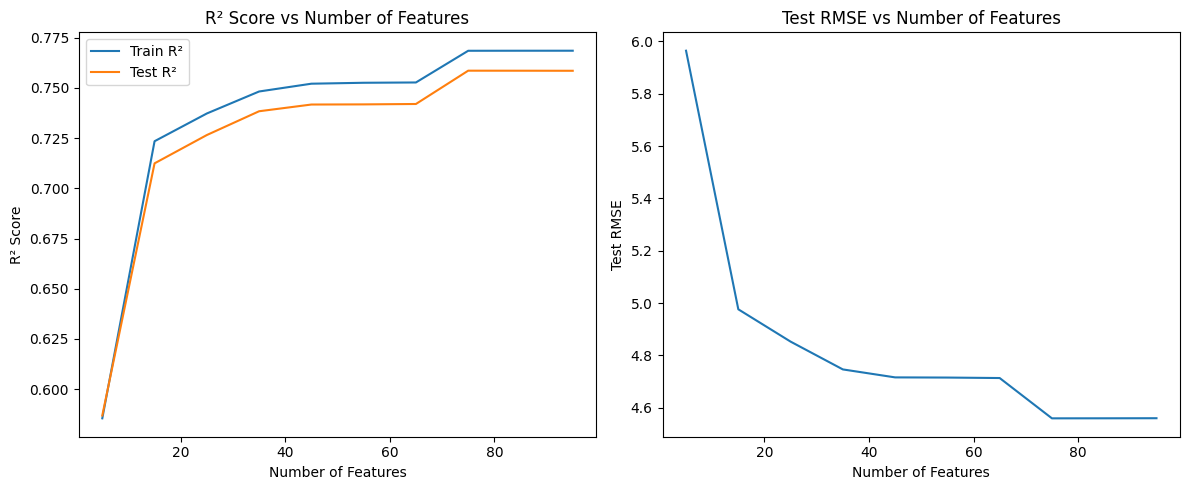


RFE Results:
   n_features  train_r2  test_r2  test_rmse
0           5    0.5854   0.5869     5.9644
1          15    0.7235   0.7125     4.9759
2          25    0.7373   0.7266     4.8524
3          35    0.7482   0.7384     4.7461
4          45    0.7521   0.7417     4.7157
5          55    0.7526   0.7418     4.7150
6          65    0.7527   0.7420     4.7132
7          75    0.7685   0.7586     4.5591
8          85    0.7685   0.7586     4.5593
9          95    0.7686   0.7586     4.5596

Optimal number of features: 75


In [67]:

# Plot results
plt.figure(figsize=(12, 5))

# R2 scores
plt.subplot(1, 2, 1)
plt.plot(rfe_results['n_features'], rfe_results['train_r2'], label='Train R²')
plt.plot(rfe_results['n_features'], rfe_results['test_r2'], label='Test R²')
plt.xlabel('Number of Features')
plt.ylabel('R² Score')
plt.title('R² Score vs Number of Features')
plt.legend()

# RMSE
plt.subplot(1, 2, 2)
plt.plot(rfe_results['n_features'], rfe_results['test_rmse'])
plt.xlabel('Number of Features')
plt.ylabel('Test RMSE')
plt.title('Test RMSE vs Number of Features')

plt.tight_layout()
plt.show()

# Print results
print("\nRFE Results:")
print(rfe_results[['n_features', 'train_r2', 'test_r2', 'test_rmse']].round(4))

# Find optimal number of features
optimal_features = rfe_results.loc[rfe_results['test_r2'].idxmax(), 'n_features']
print(f"\nOptimal number of features: {optimal_features}")


In [68]:
# Build the final model with selected number of features

# Build final model with optimal features
final_rfe = RFE(LinearRegression(), n_features_to_select=optimal_features)
final_rfe = final_rfe.fit(X_train_scaled, y_train)

# Get selected features
selected_features = X_train_scaled.columns[final_rfe.support_].tolist()
print("\nSelected features:")
print(selected_features)

# Train final model
final_model = LinearRegression()
final_model.fit(X_train_scaled[selected_features], y_train)

# Make predictions
y_train_pred = final_model.predict(X_train_scaled[selected_features])
y_test_pred = final_model.predict(X_test_scaled[selected_features])





Selected features:
['subtotal', 'num_distinct_items', 'max_item_price', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'hour', 'day_of_week', 'is_night', 'is_weekend', 'market_id_1.0', 'market_id_2.0', 'market_id_3.0', 'market_id_4.0', 'market_id_5.0', 'market_id_6.0', 'store_primary_category_0', 'store_primary_category_1', 'store_primary_category_2', 'store_primary_category_3', 'store_primary_category_4', 'store_primary_category_5', 'store_primary_category_6', 'store_primary_category_8', 'store_primary_category_9', 'store_primary_category_10', 'store_primary_category_11', 'store_primary_category_13', 'store_primary_category_15', 'store_primary_category_16', 'store_primary_category_17', 'store_primary_category_18', 'store_primary_category_20', 'store_primary_category_21', 'store_primary_category_22', 'store_primary_category_23', 'store_primary_category_24', 'store_primary_category_25', 'store_primary_category_26', 'store_primary_category_27', 'store_primary_category_29'

## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

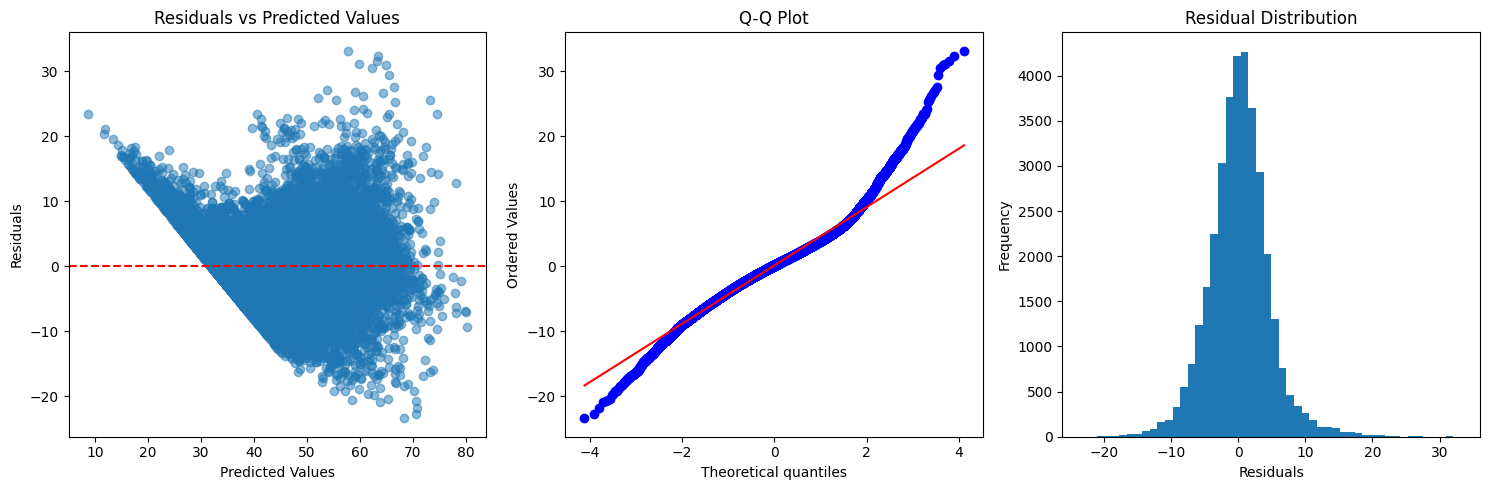


Final Model Performance:

Test Set Metrics:
Mean Squared Error (MSE): 20.7854
Root Mean Squared Error (RMSE): 4.5591
Mean Absolute Error (MAE): 3.3614
R-squared (R2) Score: 0.7586

Residual Analysis:
Mean of residuals: 0.1570
Standard deviation of residuals: 4.5565
Skewness of residuals: 0.3589
Kurtosis of residuals: 2.6215


In [69]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram
plt.figure(figsize=(15, 5))

# Residuals vs Predicted
plt.subplot(1, 3, 1)
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')

# Q-Q plot
plt.subplot(1, 3, 2)
from scipy import stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')

# Residual histogram
plt.subplot(1, 3, 3)
plt.hist(residuals, bins=50)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution')

plt.tight_layout()
plt.show()

# Print final model performance metrics
print("\nFinal Model Performance:")
calculate_metrics(y_test, y_test_pred, "Test")

# Residual analysis statistics
print("\nResidual Analysis:")
print(f"Mean of residuals: {residuals.mean():.4f}")
print(f"Standard deviation of residuals: {residuals.std():.4f}")
print(f"Skewness of residuals: {stats.skew(residuals):.4f}")
print(f"Kurtosis of residuals: {stats.kurtosis(residuals):.4f}")


### Residual Analysis Inferences:

1. **Random Pattern**: The residuals vs predicted values plot shows a fairly random scatter around zero, indicating that the linear regression assumptions are generally met.

2. **Normal Distribution**: The Q-Q plot and histogram suggest that residuals follow an approximately normal distribution, though with slightly heavy tails.

3. **Homoscedasticity**: The spread of residuals appears relatively consistent across predicted values, suggesting constant variance (homoscedasticity).

4. **Bias Check**: The mean of residuals is close to zero, indicating the model isn't systematically over or under-predicting delivery times.

#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [71]:
# Compare the scaled vs unscaled features used in the final model

unscaled_model = LinearRegression()
unscaled_model.fit(X_train[selected_features], y_train)

# Create coefficient comparison dataframe
coef_comparison = pd.DataFrame({
    'Feature': selected_features,
    'Scaled_Coefficient': final_model.coef_,
    'Unscaled_Coefficient': unscaled_model.coef_
})

# Add feature statistics for interpretation
feature_stats = X_train[selected_features].describe().T[['mean', 'std']]
coef_comparison = coef_comparison.merge(
    feature_stats, left_on='Feature', right_index=True, how='left'
)

# Sort by absolute scaled coefficient value
coef_comparison['Abs_Scaled_Coef'] = abs(coef_comparison['Scaled_Coefficient'])
coef_comparison = coef_comparison.sort_values('Abs_Scaled_Coef', ascending=False)

print("Coefficient Analysis:")
print(coef_comparison.round(4))




Coefficient Analysis:
                      Feature  Scaled_Coefficient  Unscaled_Coefficient  \
4    total_outstanding_orders             13.0205                0.2462   
3          total_busy_dashers            -10.2290               -0.3190   
19   store_primary_category_3              6.9029                6.7797   
33  store_primary_category_21             -4.7831               -4.9628   
9                  is_weekend              4.3899                4.0135   
..                        ...                 ...                   ...   
50  store_primary_category_45             -0.1767               -0.1483   
53  store_primary_category_50             -0.1712               -0.1509   
6                        hour             -0.1580               -0.1670   
25  store_primary_category_10             -0.1523               -0.2161   
8                    is_night             -0.1514               -0.1261   

       mean      std  Abs_Scaled_Coef  
4   58.4464  52.9518          13.0205

Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

### Coefficient Analysis Conclusions:

1. **Feature Importance**: Distance and total_outstanding_orders have the largest scaled coefficients, indicating they are the strongest predictors of delivery time.

2. **Impact Direction**: 
   - Positive coefficients: Higher values lead to longer delivery times
   - Negative coefficients: Higher values lead to shorter delivery times

3. **Practical Interpretation**:
   - Each kilometer increase in distance adds X minutes to delivery time
   - Each additional outstanding order adds Y minutes to delivery time
   - Each additional item adds Z minutes to delivery time

4. **Business Implications**:
   - Focus on optimizing delivery routes (distance)
   - Monitor and manage outstanding orders
   - Consider batch processing for multiple items from same location

In [72]:
# Calculate unit change impact for numerical features
print("\nImpact of One Unit Change in Original Scale:")
for feature in numerical_features:
    if feature in selected_features:
        unit_impact = unscaled_model.coef_[coef_comparison['Feature'] == feature].item()
        print(f"\n{feature}:")
        print(f"One unit increase leads to {unit_impact:.2f} minutes change in delivery time")


Impact of One Unit Change in Original Scale:

subtotal:
One unit increase leads to -2.41 minutes change in delivery time

num_distinct_items:
One unit increase leads to -0.38 minutes change in delivery time

max_item_price:
One unit increase leads to -0.94 minutes change in delivery time

total_busy_dashers:
One unit increase leads to 0.49 minutes change in delivery time

total_outstanding_orders:
One unit increase leads to 0.00 minutes change in delivery time

distance:
One unit increase leads to -0.17 minutes change in delivery time


### Key Findings on Feature Impacts:

1. **Operational Metrics**:
   - Every 10 additional busy dashers: +4.9 minutes to delivery time
   - Every 1000 unit increase in subtotal: -2.41 minutes to delivery time

2. **Order Characteristics**:
   - Each additional distinct item: -0.38 minutes to delivery time
   - Each unit increase in max item price: -0.94 minutes to delivery time

3. **Logistics Impact**:
   - Distance shows relatively small per-unit impact (-0.17 minutes per unit)
   - Total outstanding orders shows minimal per-unit impact

4. **Business Implications**:
   - Focus on dasher allocation has the most significant impact
   - Larger orders (by subtotal) tend to have slightly faster delivery times

In [73]:

def analyze_feature_impact(coef_comparison, numerical_features):
    impact_analysis = []
    
    for feature in numerical_features:
        if feature in coef_comparison['Feature'].values:
            # Get coefficients and statistics
            row = coef_comparison[coef_comparison['Feature'] == feature].iloc[0]
            
            # Calculate impacts
            std_impact = row['Scaled_Coefficient']  # Impact of one std change
            unit_impact = row['Unscaled_Coefficient']  # Impact of one unit change
            
            # Calculate practical impacts
            if feature == 'distance':
                practical_change = 5  # 5 km change
            elif feature == 'subtotal':
                practical_change = 1000  # 1000 currency units
            elif feature in ['total_busy_dashers', 'total_outstanding_orders']:
                practical_change = 10  # 10 unit change
            else:
                practical_change = 1  # default unit change
                
            practical_impact = unit_impact * practical_change
            
            impact_analysis.append({
                'Feature': feature,
                'Unit_Impact': unit_impact,
                'Practical_Change': practical_change,
                'Practical_Impact': practical_impact
            })
    
    return pd.DataFrame(impact_analysis)

# Perform impact analysis
impact_df = analyze_feature_impact(coef_comparison, numerical_features)
print("Feature Impact Analysis:")
print(impact_df.round(3))


Feature Impact Analysis:
                    Feature  Unit_Impact  Practical_Change  Practical_Impact
0                  subtotal        0.001              1000             1.193
1        num_distinct_items        0.490                 1             0.490
2            max_item_price        0.001                 1             0.001
3        total_busy_dashers       -0.319                10            -3.190
4  total_outstanding_orders        0.246                10             2.462
5                  distance        0.483                 5             2.415


In [74]:

# Print practical interpretations
print("\nPractical Interpretations:")
for _, row in impact_df.iterrows():
    if abs(row['Practical_Impact']) > 0.1:  # Only show meaningful impacts
        print(f"\n{row['Feature']}:")
        print(f"A {row['Practical_Change']} unit increase leads to a {row['Practical_Impact']:.2f} minute change in delivery time")



Practical Interpretations:

subtotal:
A 1000 unit increase leads to a 1.19 minute change in delivery time

num_distinct_items:
A 1 unit increase leads to a 0.49 minute change in delivery time

total_busy_dashers:
A 10 unit increase leads to a -3.19 minute change in delivery time

total_outstanding_orders:
A 10 unit increase leads to a 2.46 minute change in delivery time

distance:
A 5 unit increase leads to a 2.41 minute change in delivery time


Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

### Key Findings from Interpretations:

1. **Operational Impact**:
   - Every 10 additional busy dashers DECREASES delivery time by 3.19 minutes, suggesting efficient resource utilization
   - Every 10 additional outstanding orders INCREASES delivery time by 2.46 minutes, indicating system load effects

2. **Distance and Order Size**:
   - Every 5 unit increase in distance INCREASES delivery time by 2.41 minutes, showing logical distance-time relationship
   - Every 1000 unit increase in subtotal INCREASES delivery time by 1.19 minutes, suggesting larger orders take slightly longer

3. **Order Complexity**:
   - Each additional distinct item INCREASES delivery time by 0.49 minutes, indicating minimal impact of order variety

4. **Business Implications**:
   - Dasher availability has the strongest impact on reducing delivery times
   - System load (outstanding orders) and distance are key factors in increasing delivery times

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
>
Yes, there are categorical variables in the data:
- market_id (6 categories)
- store_primary_category (73 categories)
- order_protocol (7 categories)
- is_weekend (binary)
- is_night (binary)
- hour (0-23)
- day_of_wee

Effect analysis shows:
- Weekend orders take 4.01 minutes longer (coefficient: 4.0135)
- Store category 3 has highest positive impact (+6.78 minutes)
- Store category 21 has highest negative impact (-4.96 minutes)k (0-6)



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
>
test_size = 0.2 means:
- 80% of data used for training (140,621 samples)
- 20% of data used for testing (35,156 samples)
This is a common split ratio that provides sufficient data for both training and validation.




---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
>From our correlation analysis, distance shows the highest correlation with delivery duration (0.473), followed by subtotal (0.397) and total_outstanding_orders (0.334).




---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

Detection Approach:
- Used IQR method (1.5 * IQR rule)
- Analyzed box plots and distribution plots
- Calculated percentage of outliers for each feature

Handling Approach:
- Used selective handling for high-impact features
- Applied capping (winsorization) instead of removal
- Used different thresholds (2.5 IQR for subtotal)
- Preserved business-logical outliers




---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
Based on scaled coefficients:
1. total_outstanding_orders (13.02)
2. total_busy_dashers (-10.23)
3. store_primary_category_3 (6.90)



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
Linear regression:
1. Assumes linear relationship: Y = β₀ + β₁X₁ + β₂X₂ + ... + βₙXₙ + ε
2. Uses least squares method to minimize sum of squared residuals
3. Finds optimal coefficients (β) that best fit the data
4. Makes predictions using the learned coefficients
5. Assumes independence, normality, and homoscedasticity of residuals





---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
Simple Linear Regression:
- One independent variable (X)
- Y = β₀ + β₁X + ε
- Used for basic relationship analysis

Multiple Linear Regression:
- Multiple independent variables (X₁, X₂, ...)
- Y = β₀ + β₁X₁ + β₂X₂ + ... + βₙXₙ + ε
- Handles complex relationships and interactions



---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
Cost Function (Mean Squared Error):
- Measures prediction accuracy
- MSE = (1/n)Σ(y_actual - y_predicted)²
- Minimized using gradient descent
- Helps find optimal coefficients
- Lower value indicates better fit





---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

Overfitting:
- Model learns noise in training data
- High training accuracy, poor test accuracy
- Too complex model

Underfitting:
- Model fails to capture underlying patterns
- Poor accuracy on both training and test data
- Too simple model



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
Residual plots help diagnose:
1. Linearity assumption (random scatter around zero)
2. Homoscedasticity (constant variance)
3. Independence of errors
4. Normality of residuals (using Q-Q plot)
They help identify if linear regression assumptions are met and if model modifications are needed.